# 나의 첫 번째 캐글 경진대회 집 값 예측하기 

### 기본적인 Workflow 구상하기 🚞

**1. 문제 확인 및 데이터 수집** \
  1.1 풀고자 하는 문제 확인 \
  1.2 데이터 수집
  
**2. 데이터 탐색** \
  2.1 변수 확인 \
  2.2 종속변수 시각화 (price) \
  2.3 독립변수 시각화 (다양한 변수) - 종속변수와의 상관관계 \
  2.4 결론 

**3. 데이터 전처리** \
  3.1 이상치 제거 \
  3.2 데이터 정규화 \
  3.3 데이터 변형 (변수 수정) 
  
**4. 모델링** \
  4.1 단순 선형회귀(OLS) \
  4.2 변수 삭제 \
  4.3 Grid Search \
  4.4 모델의 학습 및 예측 \
  4.5 Averaged base models class \
  4.6 StackingAveragedModels 
  
**5. 결과** \
  5.1 모델 별 RMSE \
  5.2 Averaged base models class RMSE \
  2.3 StackingAveragedModels RMSE
  
**6. submission**

**7. 회고**

### 1. 문제 확인 및 데이터 수집

### 1.1 문제확인

* 다양한 정보들을 가지고 **집값**을 예측하는 문제
* 예측해야 하는 값과 실제 정답값이 모두 실숫값
* 어떤 카테고리에 속하는지를 맞추는 문제가 아니라, 실수값을 맞추는 문제이므로 회귀 문제
* RMSE를 평가 척도로 사용

In [83]:
! pip install pandas_profiling
! pip install catboost

In [84]:
# 필요한 라이브러리 불러오기
import os
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # 그래프를 더 높은 해상도로 출력한다.

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None) 

import pandas_profiling
import numpy as np
import missingno as msno
import scipy as sp
import folium 
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
# pip install catboost
from sklearn.model_selection import KFold 
from scipy.stats import norm
from scipy import stats, linalg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from folium import plugins
from sklearn import linear_model 
from sklearn import neighbors 
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing 
from math import log
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

### 1.2 데이터 수집

In [85]:
# 데이터 경로 지정하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

# 데이터를 df_train, df_test이라는 변수로 불러오기
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(df_train.shape))
print('test data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


* Train 데이터는 약 1만 5천 개, Test 데이터는 약 6천 개로 이루어져 있다.
* Train 데이터와 Test 데이터의 비율은 5:2로 심하게 불균등하지 않다. 
* 테스트 데이터는 물론 우리가 맞추어야 할 집의 가격, price가 없기 때문에 컬럼이 하나 적다.

### 2. 데이터 탐색

### 2.1 변수확인

1. ID : 집을 구분하는 번호

2. date : 집을 구매한 날짜

3. **price** : 타겟 변수인 집의 가격

4. bedrooms : 침실의 수

5. bathrooms : 침실 당 화장실 개수 (화장실 수 0.5는 화장실은 있지만 샤워시설은 없음)

6. sqft_living : 주거 공간의 평방 피트

7. sqft_lot : 부지의 평방 피트

8. floors : 집의 층수

9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

10. view : 집이 얼마나 좋아 보이는지의 정도

11. condition : 집의 전반적인 상태

12. grade : King County grading 시스템 기준으로 매긴 집의 등급

13. sqft_above : 지하실을 제외한 평방 피트

14. sqft_basement : 지하실의 평방 피트

15. yr_built : 집을 지은 년도

16. yr_renovated : 집을 재건축한 년도

17. zipcode : 우편번호

18. lat : 위도

19. long : 경도

20. sqft_living15 : 근처 15가구의 주거 공간, 평방 피트

21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

참고
* https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html

In [86]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* `date` : yyyymmdd + T000000의 형태. 필요한 부분은 앞의 8자리(yyyymmdd)
* `bathroom` : 소수점 형태
* `yr_renovated` : 0인 값은 재건축을 하지 않았다는 의미
* 앞으로 하나하나 변수를 살펴보면서 전처리와 피쳐 엔지니어링에 대해 고민해본다. 

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

* 데이터 타입이 대부분 실수, 정수로 이루어져 있으나, date는 objcet로 되어있다.
* 앞에서 확인한 바와 같이 date는 yyyymmdd + T000000의 형태로 되어있음.
* 필요한 부분인 앞의 8자리(yyyymmdd)만 불러와 정수형태로 바꿔야 함.

In [88]:
# 'data_ID' 변수에 `id`칼럼 저장
df_train_ID = df_train['id']
df_test_ID = df_test['id']

# `id` 칼럼 삭제
df_train.drop("id", axis = 1, inplace = True)
df_test.drop("id", axis = 1, inplace = True)

# date 컬럼은 apply 함수로 필요한 부분만 잘라준다.
df_train['date'] = df_train['date'].apply(lambda x : str(x[:6]))
df_test['date'] = df_test['date'].apply(lambda x : str(x[:6]))

In [89]:
df_train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* 필요 없는 `id` 컬럼 제거
* 나중에 예측 결과를 제출할 때를 대비해 'train_ID' 변수에 `id`칼럼 저장
* `date`를 필요한 부분인 앞의 8자리(yyyymmdd)만 표현해 준다.

<AxesSubplot:>

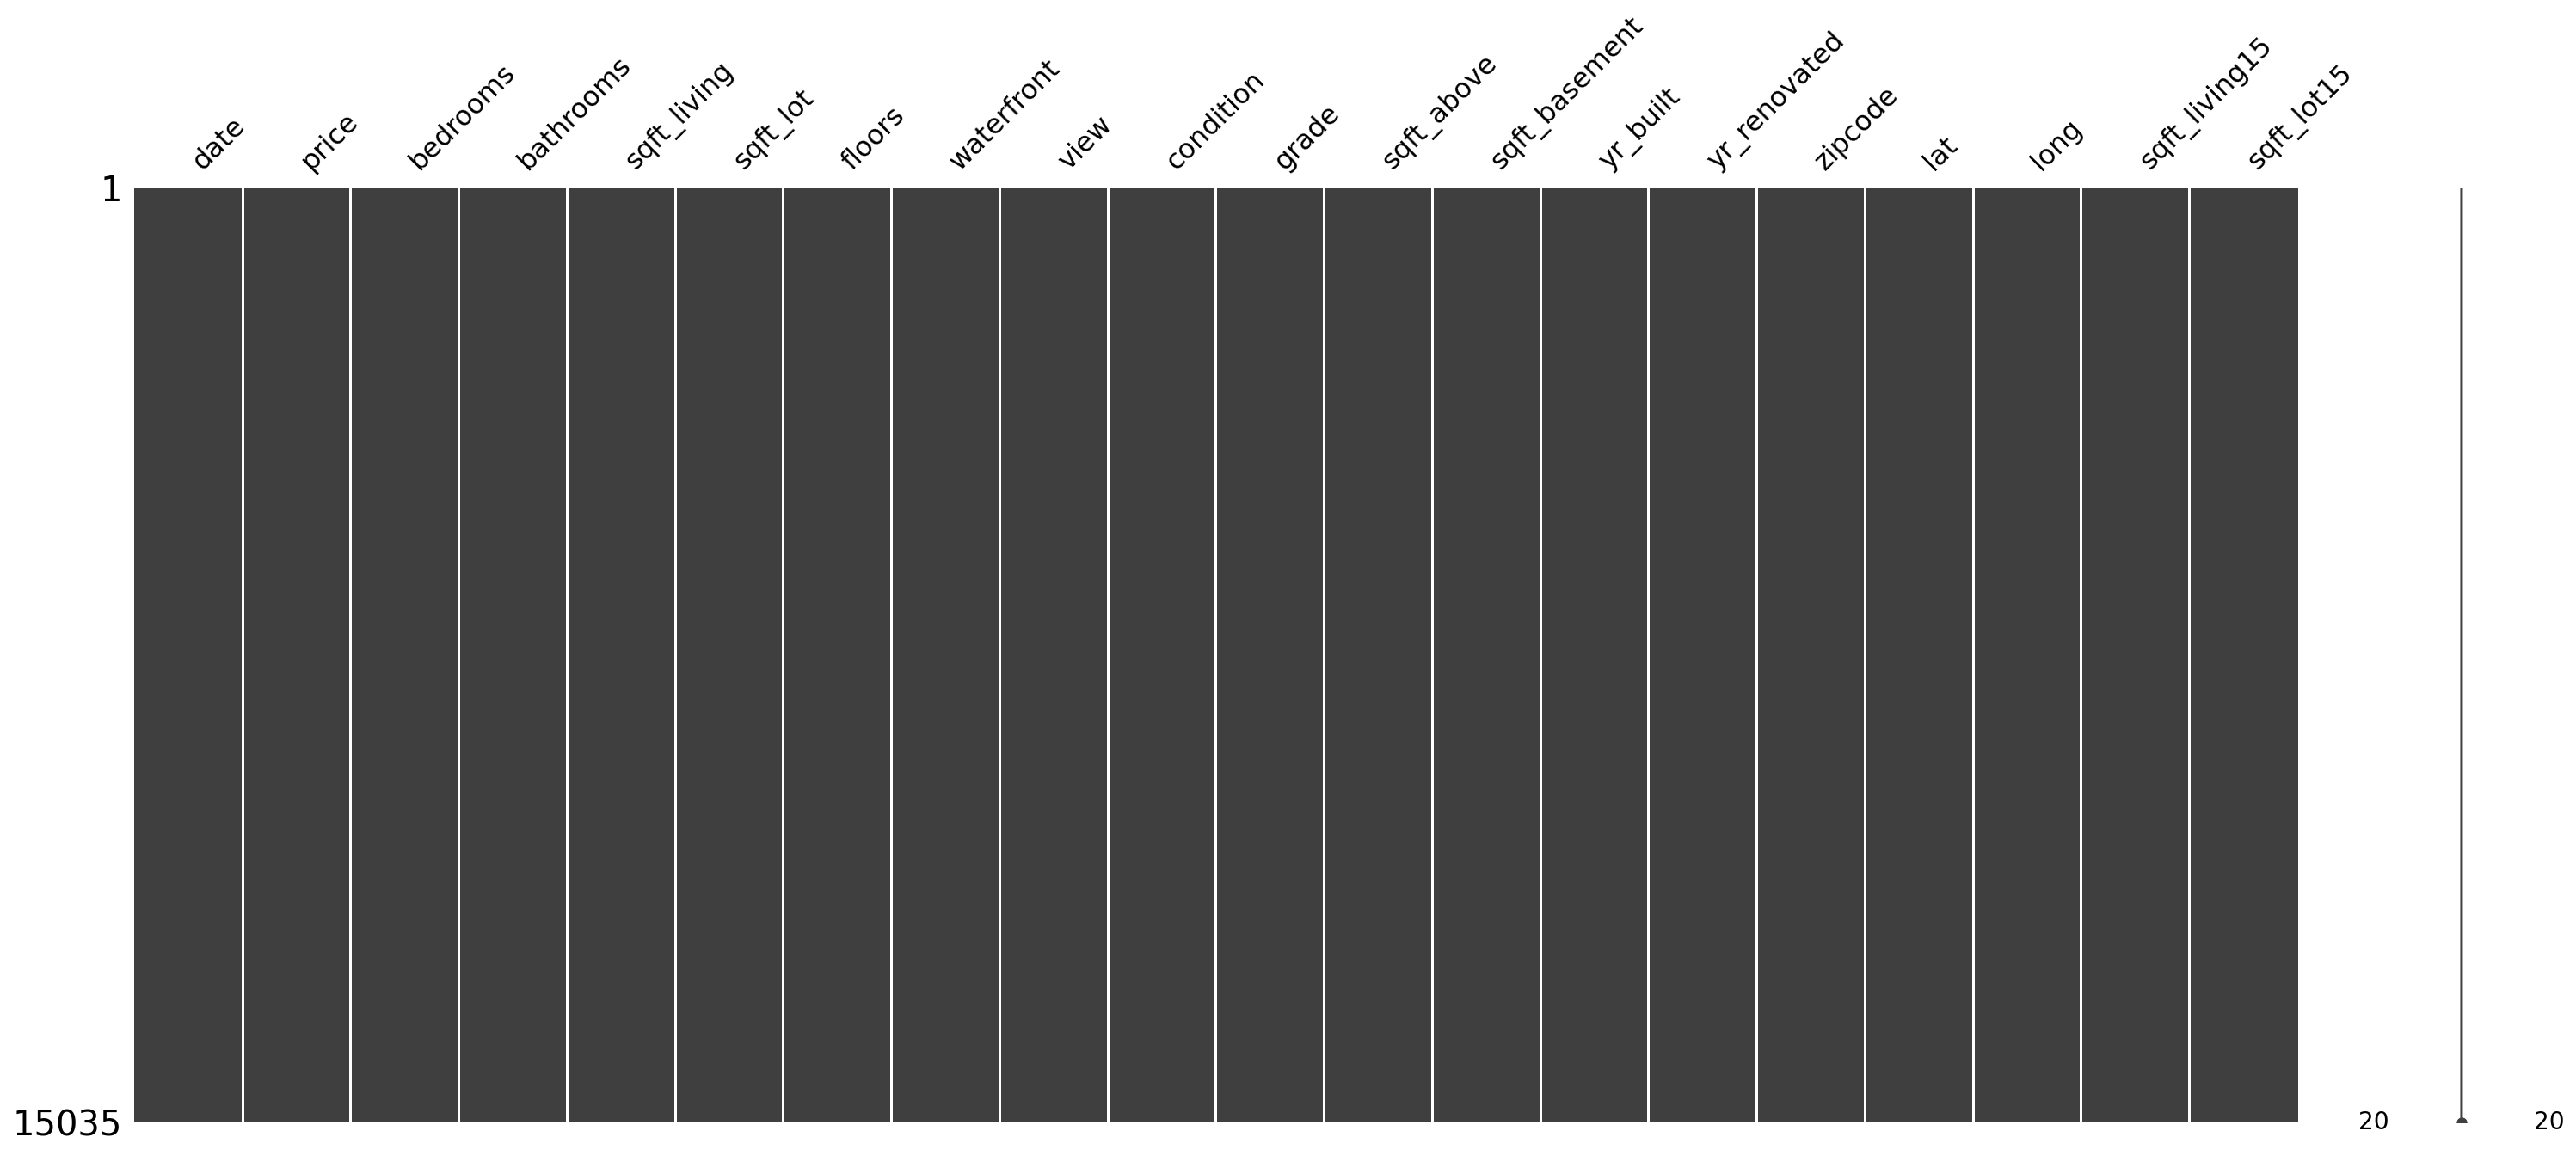

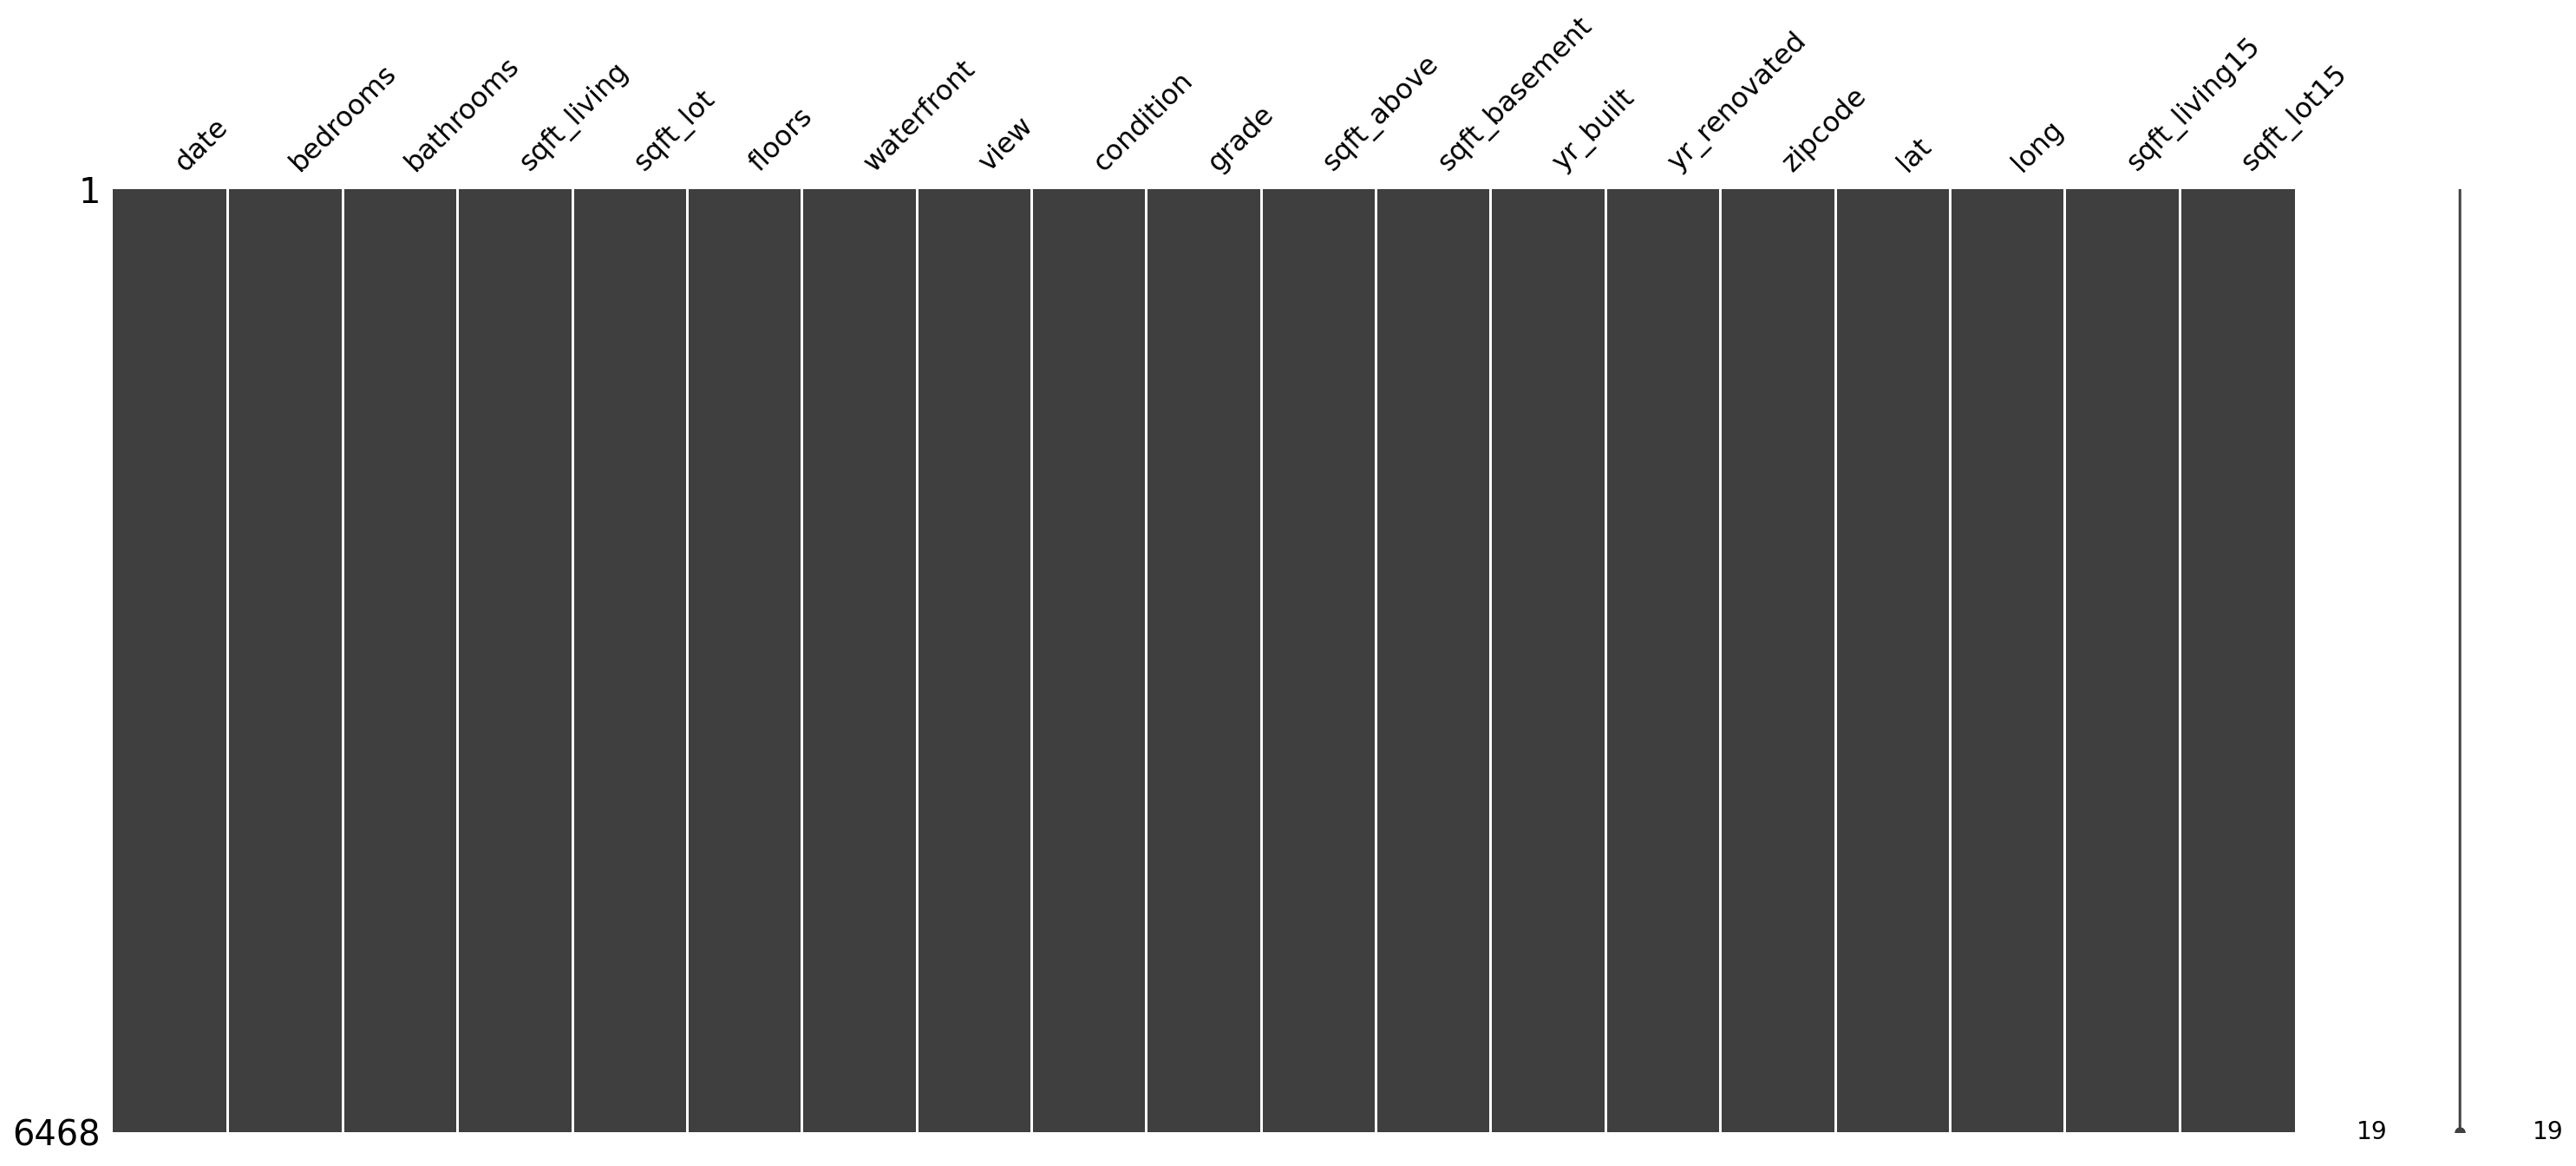

In [90]:
import missingno as msno
msno.matrix(df_train)
msno.matrix(df_test)

* 데이터 상 결측치가 없는 것도 위 그래프에서 확인이 가능하다. 

### 2.2 종속변수 시각화 (price)

In [91]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

* `prince`의 경우 min, max의 차이가 크고, std가 굉장히 크다.

<AxesSubplot:xlabel='price', ylabel='Density'>

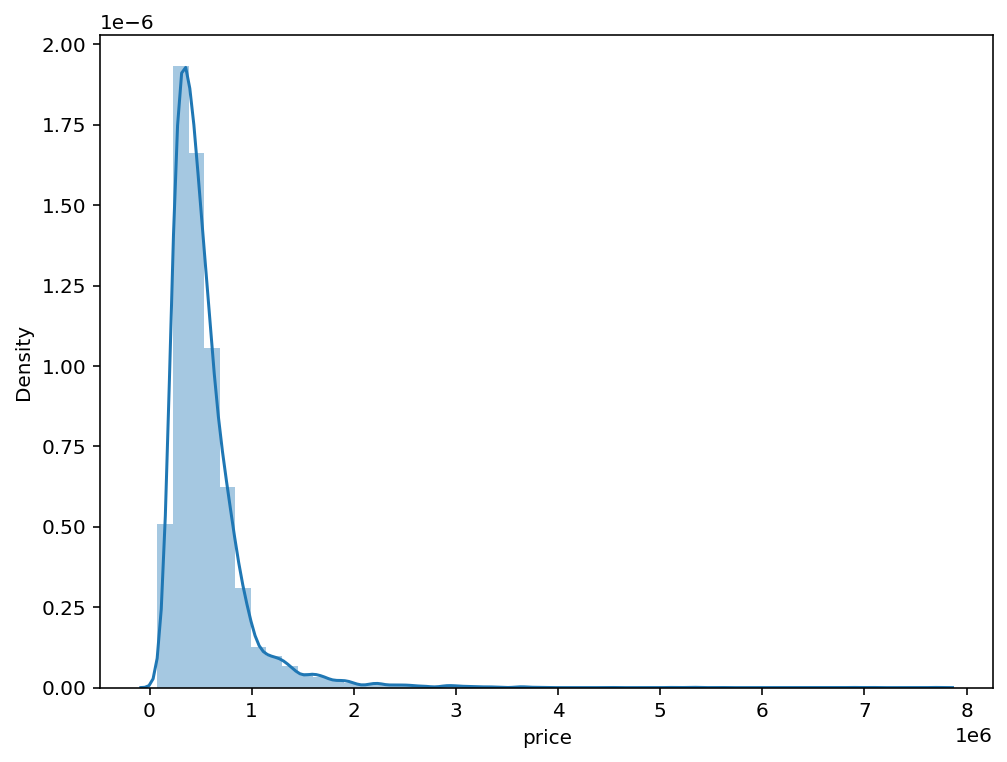

In [92]:
# price의 histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [93]:
# 왜도, 첨도 확인하기
print("Skewness(왜도): %f" % df_train['price'].skew())
print("Kurtosis(첨도): %f" % df_train['price'].kurt())

Skewness(왜도): 4.290252
Kurtosis(첨도): 40.154919


* 수치 상으로나, 그래프 상으로나 `price`의 수치들이 굉장히 편향되어있다는 것을 확인할 수 있다.
* 예측모델을 회귀모델을 사용할 예정이므로 Normalize를 통해 정규분포를 가지도록 만들어 준다.

* 왜도와 첨도 이해하기
  * **왜도** : symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
  * **첨도** : 첨도는 분포 그래프의 꼬리 부분에 관한 것이다. 정점(peakness)이나 평탄도(flatness)가 아니다. 극단적인 값들을 한 꼬리와 다른 꼬리로 설명하는 데 사용된다. 분포에 존재하는 특이치(outlier)의 척도이다. 
    * 표준 정규 분포는 3의 첨도 갖는다.
    * Leptokurtic (Kurtosis > 3) : 분포가 길고, 꼬리가 더 뚱뚱하다. 피크는 Mesokurtic보다 높고 날카롭기 때문에 데이터는 꼬리가 무겁거나 특이치(outlier)가 많다는 것을 의미한다.
    * Platykurtic (Kurtosis < 3) : 분포는 짧고 꼬리는 정규 분포보다 얇다. 피크는 Mesokurtic보다 낮고 넓으며, 이는 데이터가 가벼운 편이나 특이치(outlier)가 부족하다는 것을 의미한다.

참고 
* https://dining-developer.tistory.com/17
* https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

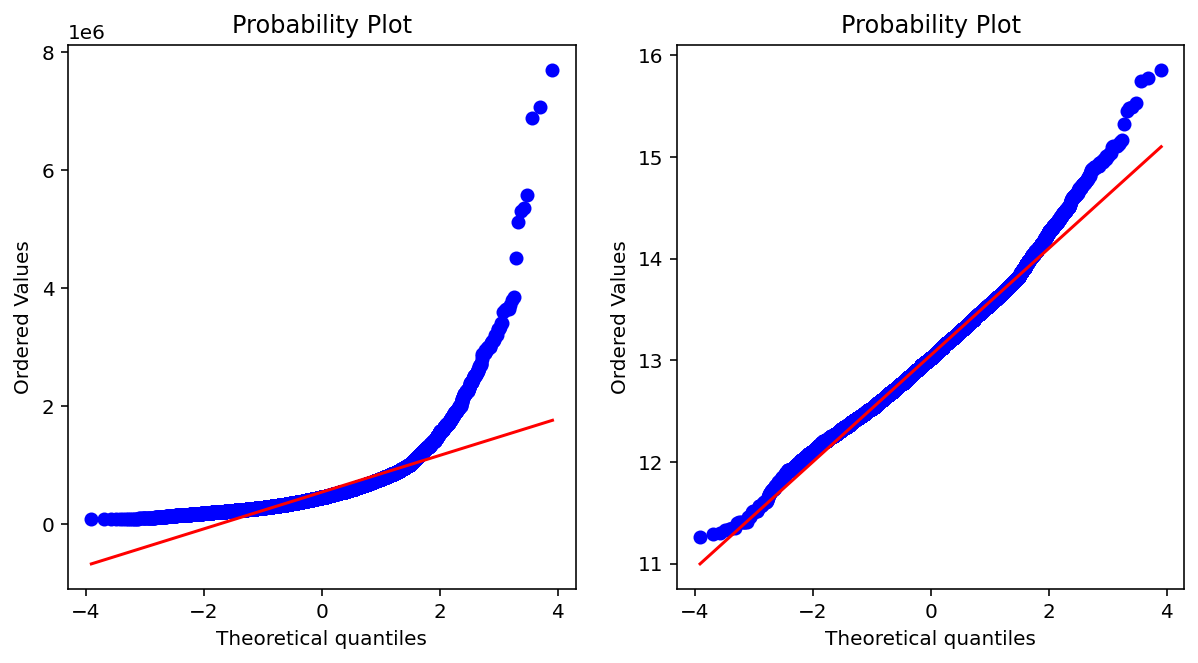

In [94]:
fig = plt.figure(figsize = (10,5))
# Normalize 전
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)
# Normalize 후
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)   # 로그변환

<AxesSubplot:xlabel='price', ylabel='Density'>

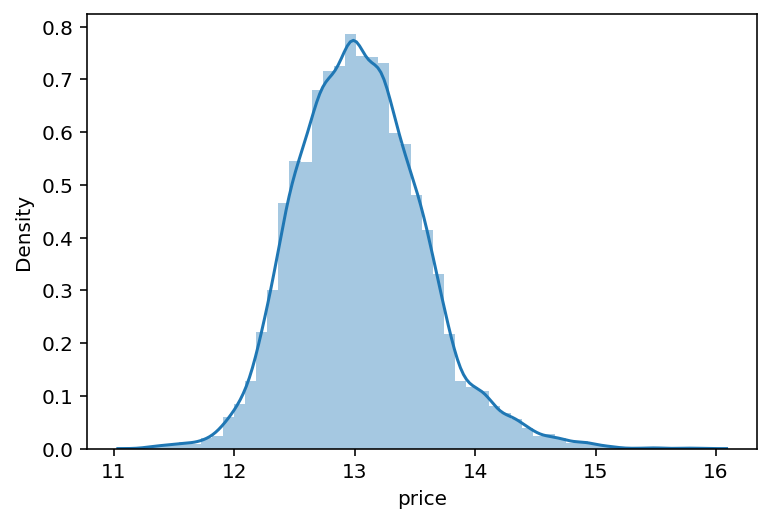

In [95]:
df_train['price'] = np.log1p(df_train['price'])   # 로그변환
#price의 normalize 후 histogram
f, ax = plt.subplots(figsize=(6, 4))
sns.distplot(df_train['price'])

* 위와 같이 `price`에 log를 취하면 정규성을 띄게 된다.  

### 2.3 독립변수 시각화 (다양한 변수) - 종속변수와의 상관관계

* 데이터 세트에서 사용할 수 있는 독립변수와 예측하려는 종속변수(가격) 간의 관계를 분석한다. 
* 변수 간의 잠재적 연관성을 탐색하기 위해 산점도와 상관계수(Pearson, Spearman)를 사용한다.
* 연속형 변수(Continuous Variables), 범주형 변수(Categorical Variables)로 나눠서 확인한다.
* 참고 \
https://lunch-box.tistory.com/94

### 2.3.1 연속형 변수(Continuous Variables)

* sqft_living
* sqft_lot
* sqft_above (i.e., sqft_above = sqft_living - sqft_basement)
* sqft_basement
* sqft_living15, the average house square footage of the 15 closest neighbours
* sqft_lot15, the average lot square footage of the 15 closest neighbours
* yr_built
* yr_renovated
* lat
* long

* sqft_living과 price 간의 관계를 분석해본다.
* 두 변수는 연속형 변수이므로 Pearson계수 $r$을 사용해 관계의 강도와 방향을 측정할 수 있다.

(0.6979070299928941, 0.0)


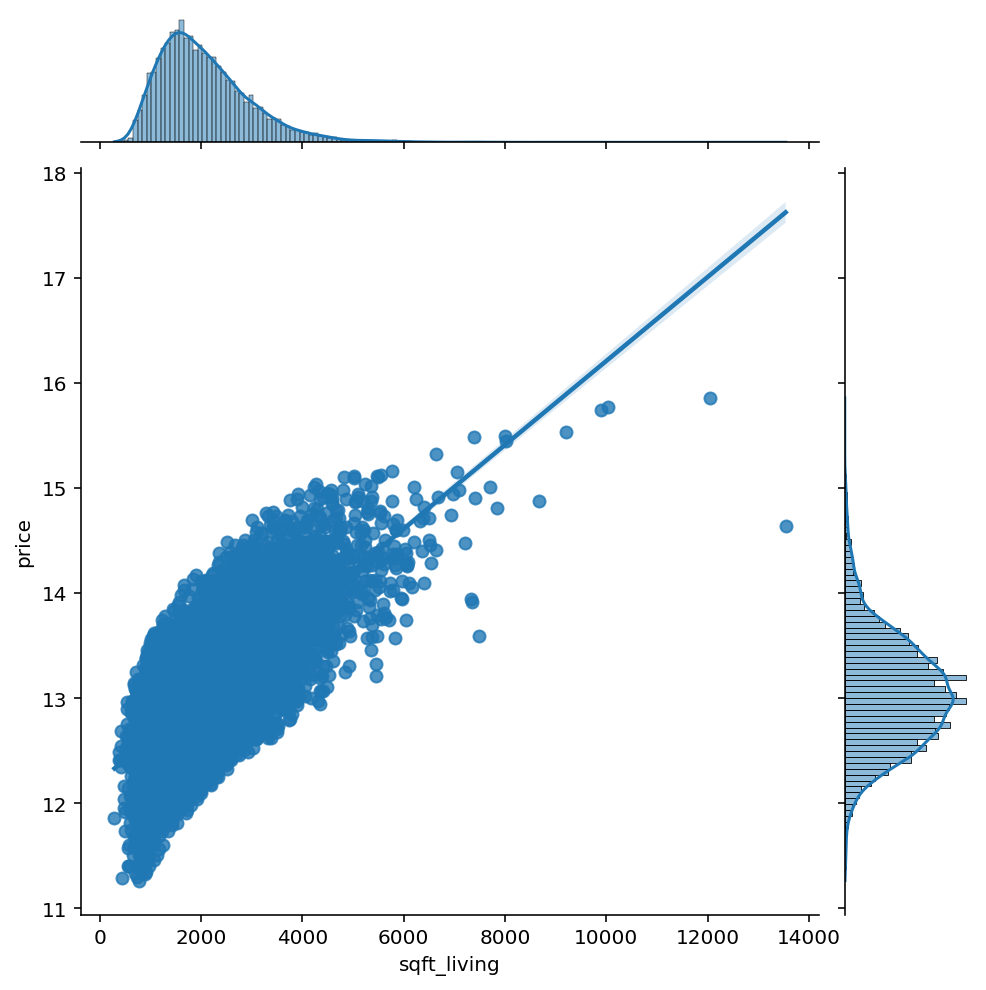

In [96]:
print(stats.pearsonr(x=df_train["sqft_living"], y=df_train["price"]))
sns.jointplot(x="sqft_living", y="price", data=df_train, kind = 'reg', size = 7)
plt.show()

* 두 변수 사이에는 명확한 선형 연관성이 있으며($r=0.69$), 강한 양의 관계를 나타낸다. 
* `sqft_living`은 집값의 좋은 예측 변수로 사용할 수 있다.
* `sqft_living` 분포도 왼쪽으로 치우쳐 있다.

(0.1089458158200705, 6.259924536667908e-41)


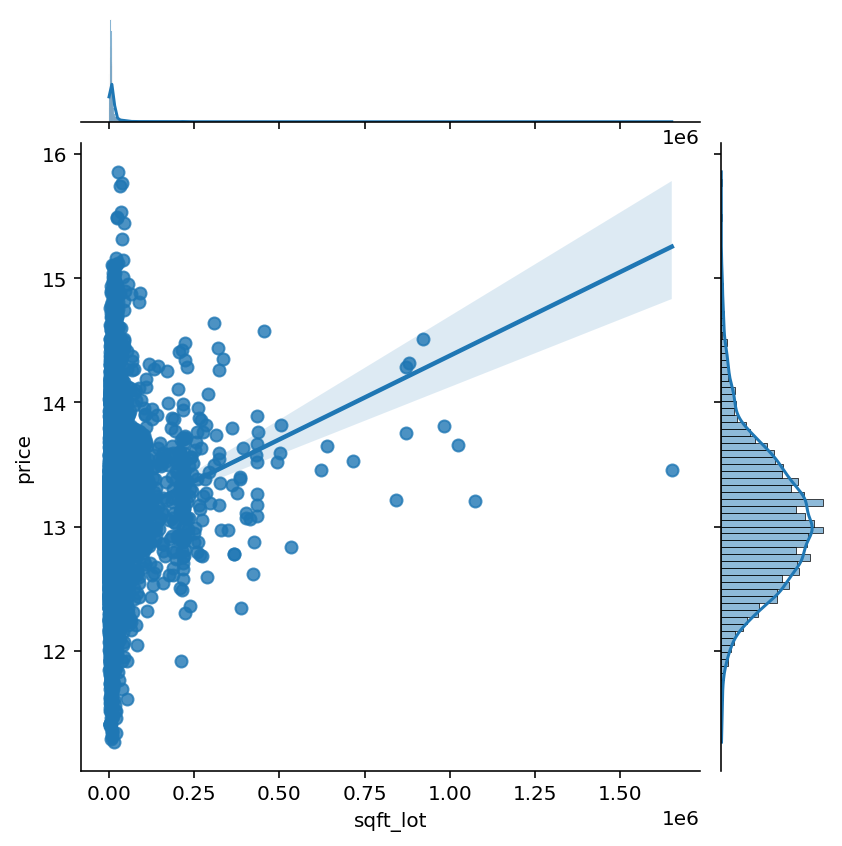

In [97]:
# 나머지 변수에 대해서도 확인하기
print(stats.pearsonr(x=df_train["sqft_lot"], y=df_train["price"]))
sns.jointplot(x="sqft_lot", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.6071968710886724, 0.0)


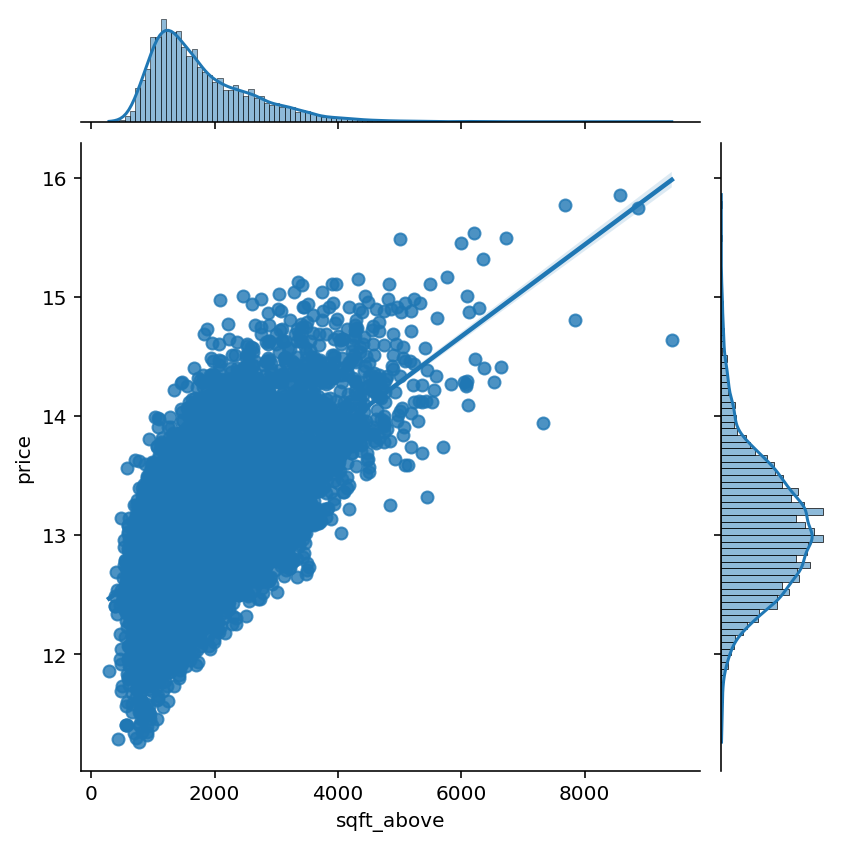

In [98]:
print(stats.pearsonr(x=df_train["sqft_above"], y=df_train["price"]))
sns.jointplot(x="sqft_above", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.3143778619617312, 0.0)


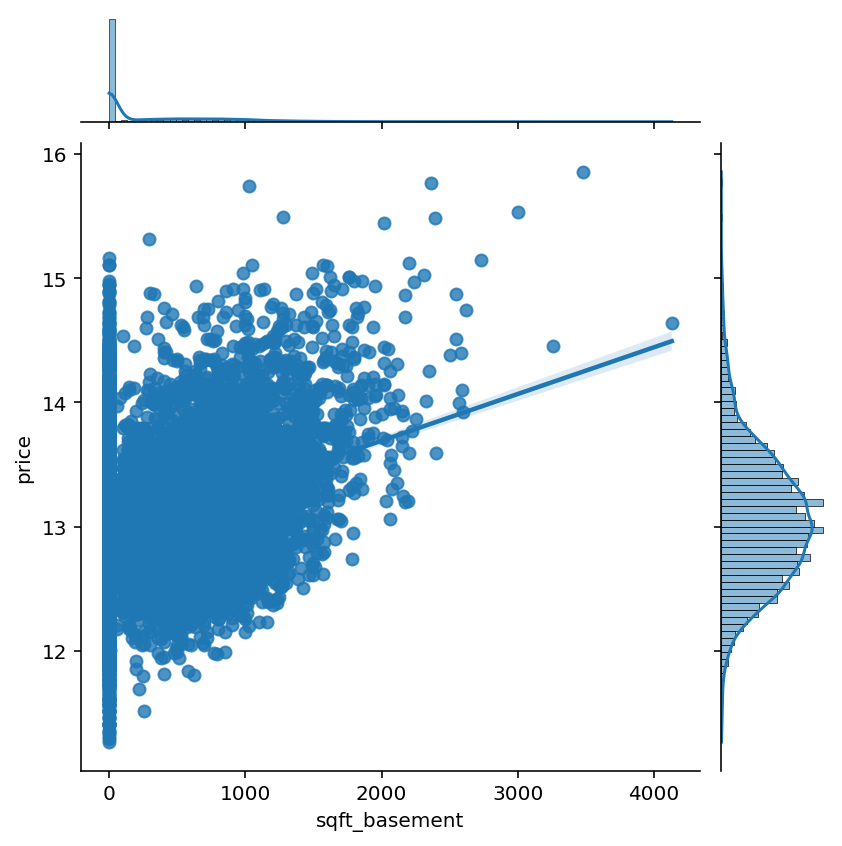

In [99]:
print(stats.pearsonr(x=df_train["sqft_basement"], y=df_train["price"]))
sns.jointplot(x="sqft_basement", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.6218002043419212, 0.0)


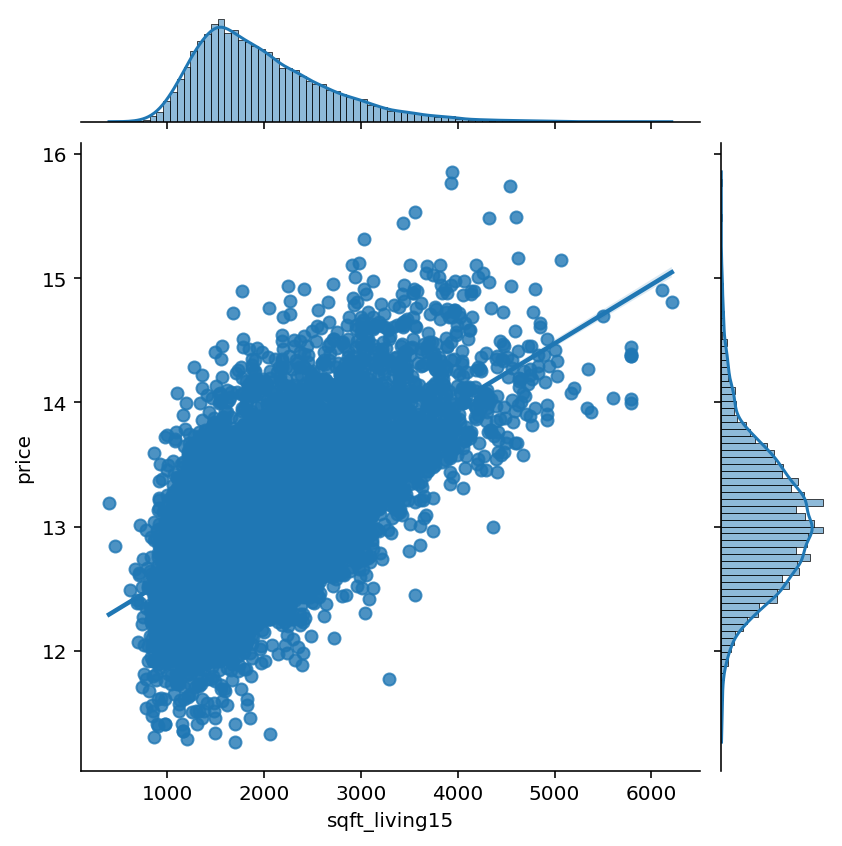

In [100]:
print(stats.pearsonr(x=df_train["sqft_living15"], y=df_train["price"]))
sns.jointplot(x="sqft_living15", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.0969762247337608, 9.528900012032072e-33)


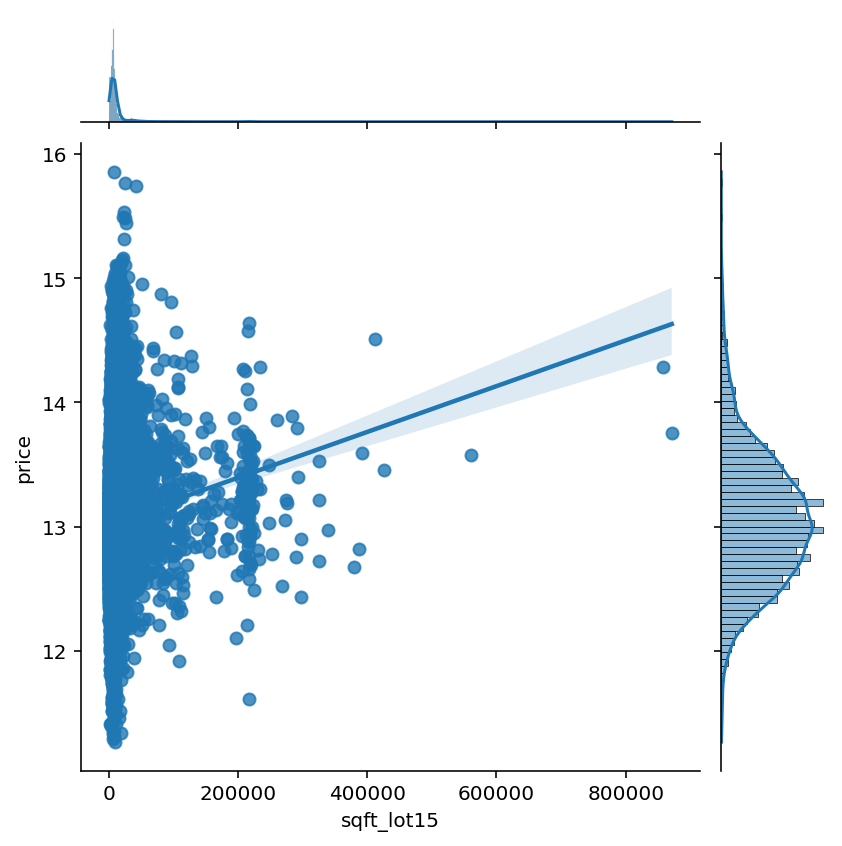

In [101]:
print(stats.pearsonr(x=df_train["sqft_lot15"], y=df_train["price"]))
sns.jointplot(x="sqft_lot15", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.0762934274348525, 7.40806968627676e-21)


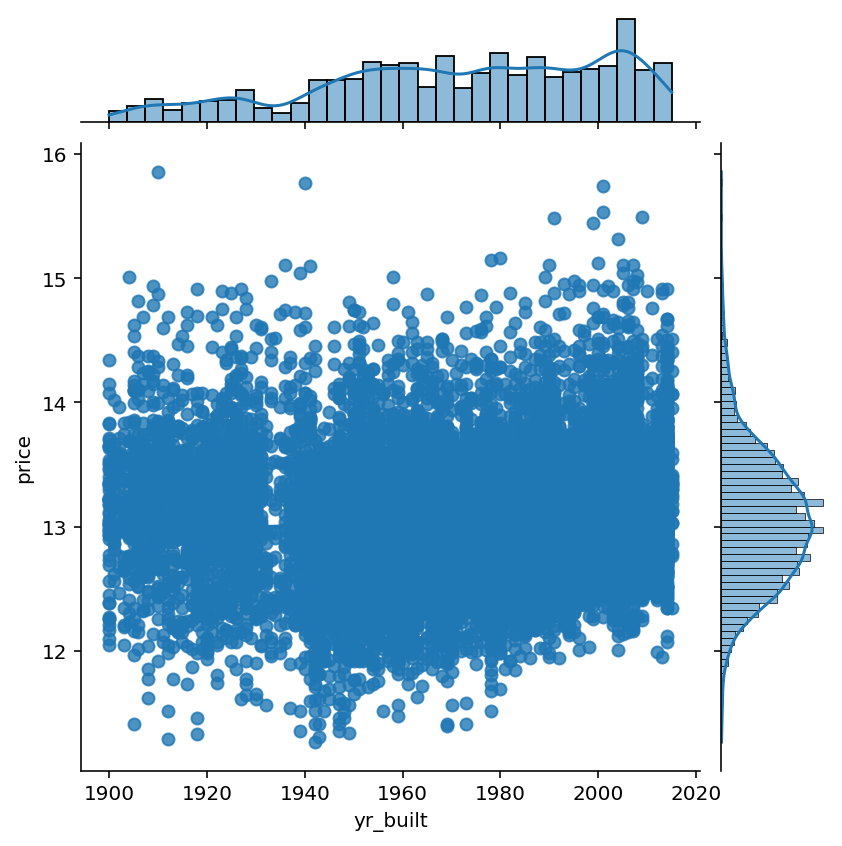

In [102]:
print(stats.pearsonr(x=df_train["yr_built"], y=df_train["price"]))
sns.jointplot(x="yr_built", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.1275327318738892, 1.4990191405098697e-55)


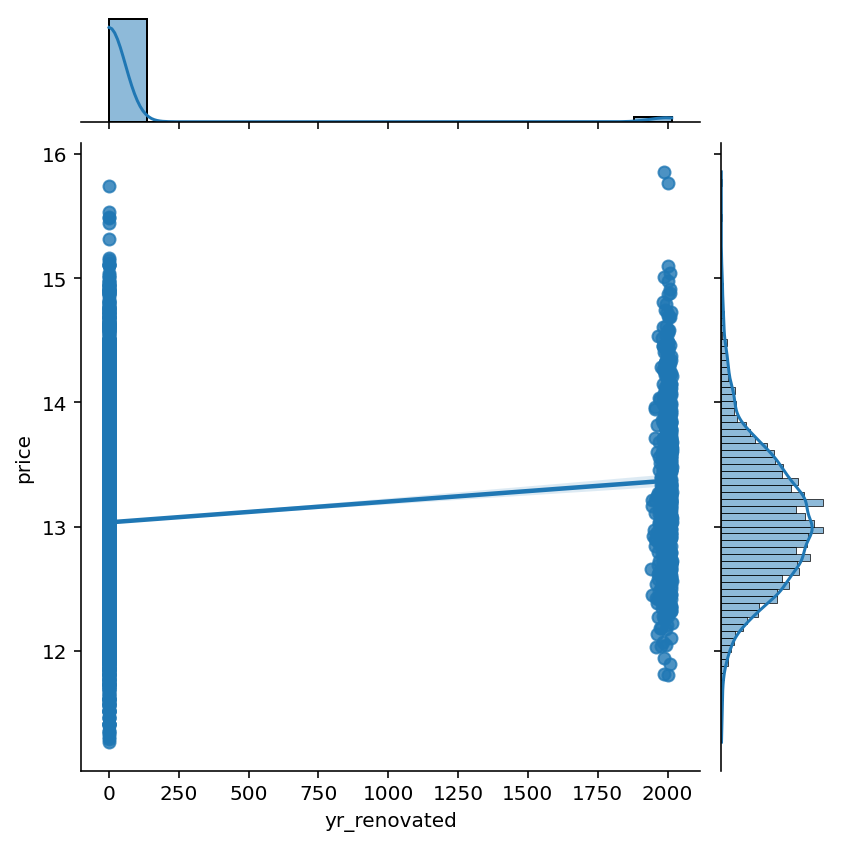

In [103]:
print(stats.pearsonr(x=df_train["yr_renovated"], y=df_train["price"]))
sns.jointplot(x="yr_renovated", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

(0.44441709755426134, 0.0)


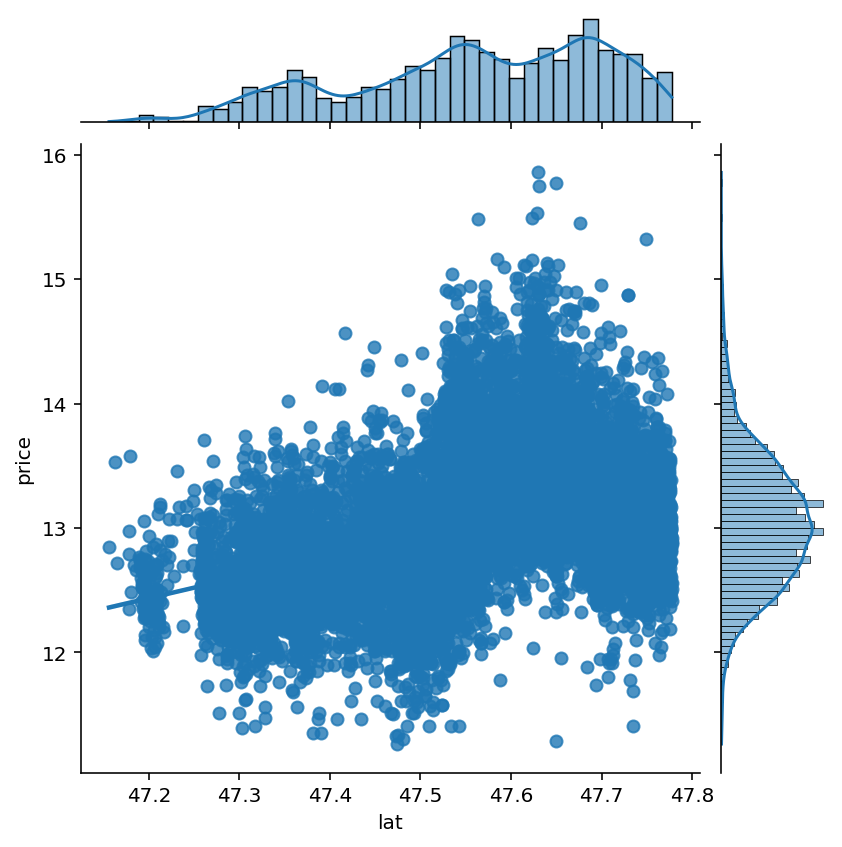

In [104]:
print(stats.pearsonr(x=df_train["lat"], y=df_train["price"]))
sns.jointplot(x="lat", y="price",data=df_train, kind = 'reg', size = 6)
plt.show()

(0.05436231117602357, 2.555640631768941e-11)


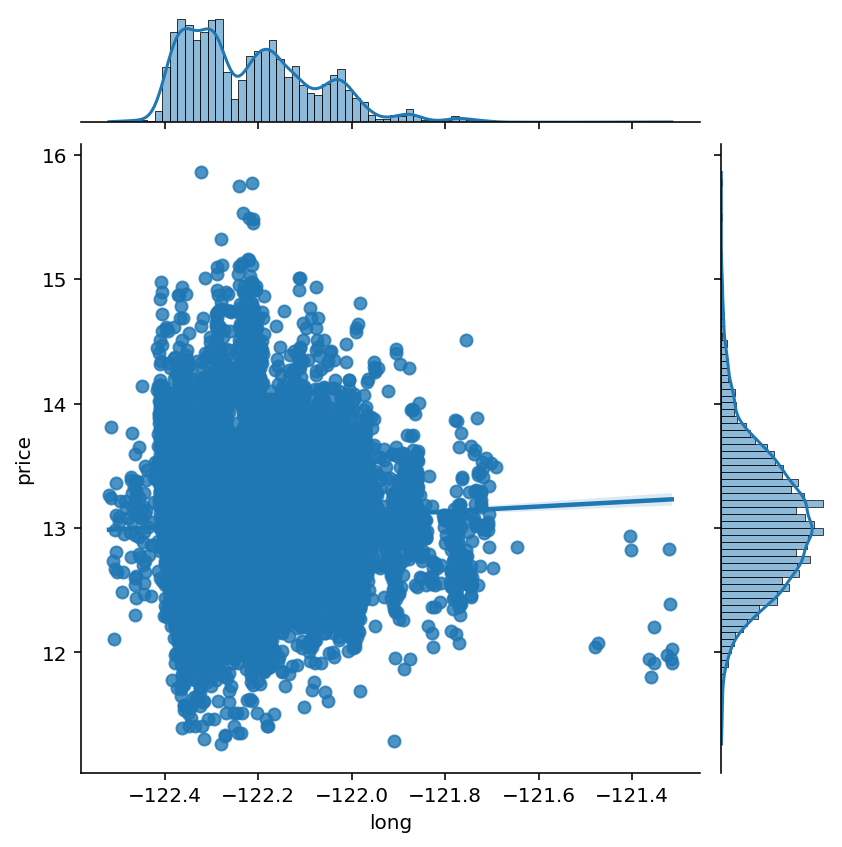

In [105]:
print(stats.pearsonr(x=df_train["long"], y=df_train["price"]))
sns.jointplot(x="long", y="price", data=df_train, kind = 'reg', size = 6)
plt.show()

* `sqft_lot`, `sqft_lot15` 및 `yr_built`는 가격과 관련이 없는 것 같다.
* `sqft_basement` 분포에 0이 많이 있음을 알 수 있다.이는 지하실이 없는 주택을 나타낸다. (이 경우 sqft_lving = sqft_above)
* 마찬가지로, `yr_renovated` 변수에는 0이 많이 있어 특정 항목이 개조된 적이 없음을 나타낸다.
* 0이 없는 이 두 변수에 대한 연관 테스트를 다시 실행해본다.

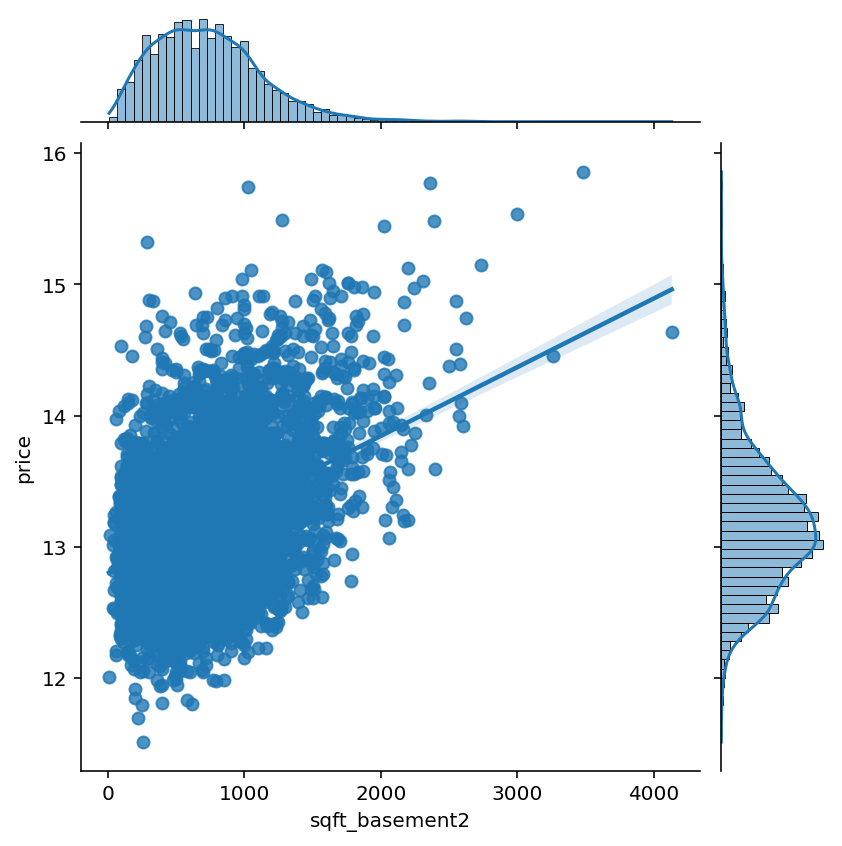

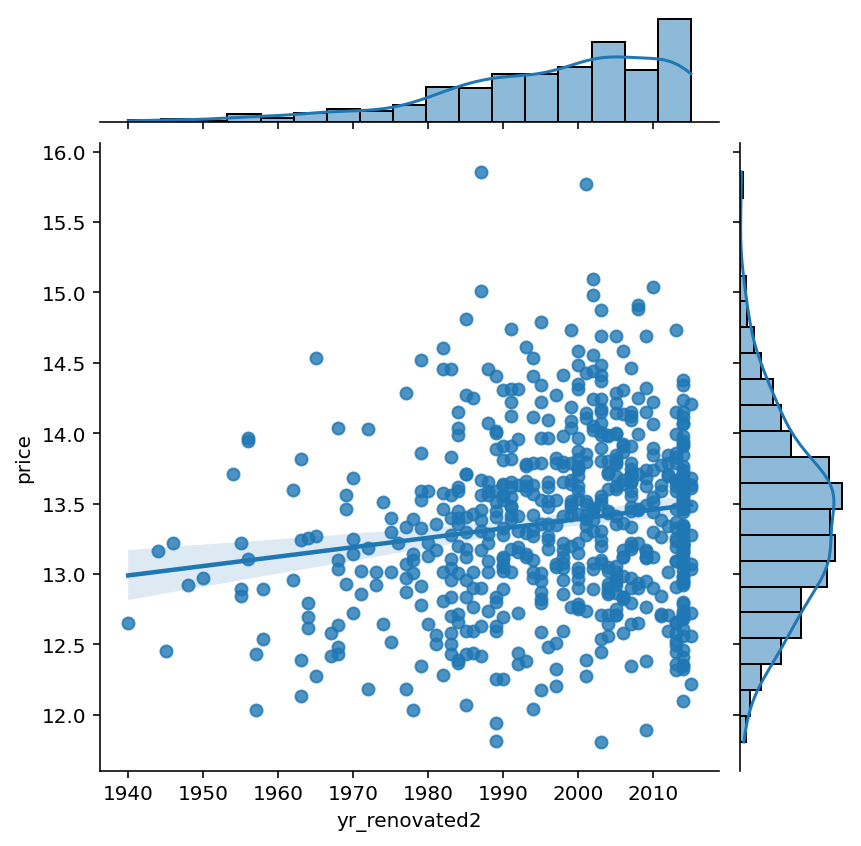

In [106]:
# 분석을 위한 2개의 새로운 칼럼을 만든다.
df_train['sqft_basement2'] = df_train['sqft_basement'].apply(lambda x: x if x > 0 else None)
df_train['yr_renovated2'] = df_train['yr_renovated'].apply(lambda x: x if x > 0 else None)

# 다시 그래프 그리기
sns.jointplot(x="sqft_basement2", y="price", data=df_train, kind = 'reg', dropna=True, size = 6)
sns.jointplot(x="yr_renovated2", y="price", data=df_train, kind = 'reg', dropna=True, size = 6)
plt.show()

* price는 지하실의 크기와 중간 정도의 상관관계가 있다. (지하실이 있는 경우)
* 재건축 연도(재건축된 경우)와도 약간의 상관관계가 있다.
* 여기에서는 지하실과 재건축 값을 이분법적 변수로 분류해 사용한다.(지하실이 없는 경우 0, 지하실이 있는 경우 1)
* 데이터 세트에 각각 새 열을 생성한다.

In [107]:
df_train['basement_present'] = df_train['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
df_train['basement_present'] = df_train['basement_present'].astype('category')

df_train['renovated'] = df_train['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df_train['renovated'] = df_train['renovated'].astype('category')

* 새로 만들어진 변수를 범주형으로 분석한다.
* 그 전에 `sqft_above` 및 `sqft_living15`를 살펴본다. 
* seaborn의 `pairgrid()` 함수를 사용하여 이들의 연관성(`sqft_living`과 함께)을 분석한다.
* 대각선 축에 각 변수의 분포를 그리고 위쪽 대각선에 산점도를 사용하고, 아래쪽 대각선에 커널 밀도 추정을 사용하여 분포를 그린다. 각 쌍의 페어슨 계수를 표시하는 함수를 생성한다.

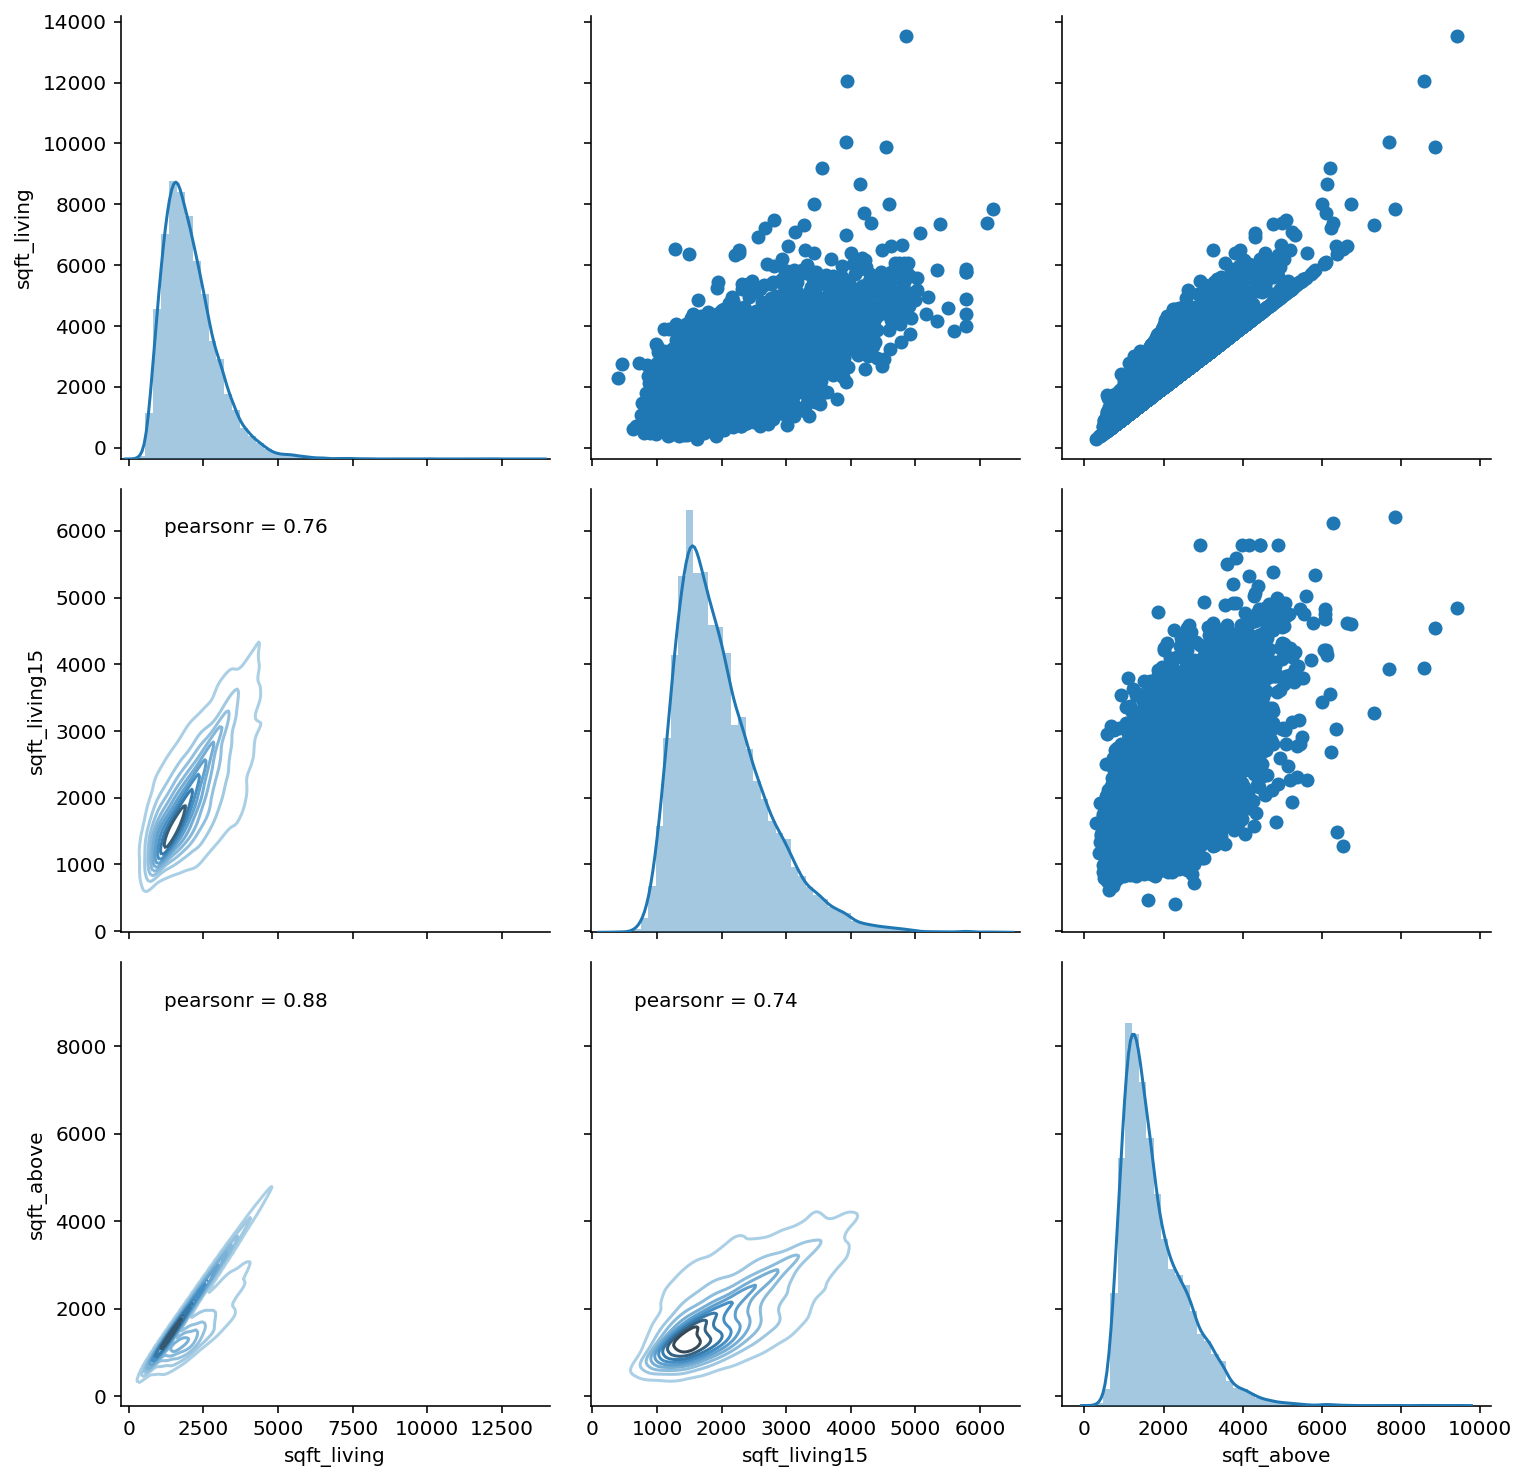

In [108]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("pearsonr = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df_train, vars = ['sqft_living', 'sqft_living15', 'sqft_above'], size = 3.5)
g.map_upper(plt.scatter) 
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
plt.show()

* 예상대로 3개의 변수 사이에는 강한 양의 관계가 확인된다.
* `sqft_livng - sqft_basement = sqft_above`의 관계를 갖기 때문에 둘 다 `price`에 영향을 미친다는 것은 예상 가능한 부분
* 그러나 `sqft_living15`의 경우 `price`와의 관계가 15가구의 평방 피트 때문인지는 확실하지 않다. 이는 `sqft_living15`와 `sqft_living` 사이의 높은 상관 관계 때문와 `sqft_livin`g 사이의 높은 상관 관계 때문이다.
* `price`와 `sqft_living15` 사이의 관계를 명확하게 평가하기 위해 Pearson Partial Correlation test를 사용한다.
* 상관 관계는 공변량(covariate)이라고 하는 다른 연속 변수의 효과를 제어하면서 두 연속 변수 간의 연관성을 평가할 수 있다.
* 여기서는 `sqft_living`을 공변량으로 사용하여 `price`와 `sqft_living15` 간의 관계를 확인한다.

* 공변량 : 독립변수라기 보다는 하나의 개념으로서 여러 변수들이 공통적으로 함께 공유하고 있는 변량
* 참고 \
https://m.blog.naver.com/imchaehong/10033930690

In [109]:
def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot(beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

partial_corr_array_df = pd.DataFrame(df_train, columns=['price', 'sqft_living', 'sqft_living15'])

partial_corr_array = partial_corr_array_df.to_numpy()

partial_corr(partial_corr_array)

array([[1.        , 0.08098428, 0.56430788],
       [0.08098428, 1.        , 0.72311321],
       [0.56430788, 0.72311321, 1.        ]])

* 주변 주택의 평균 주택 크기는 주택 크기를 제어할 때 판매 가격에 영향을 미치지 않음을 알 수 있다.

### 2.3.2 범주형 변수(Categorical Variables)

* waterfront
* basement_present
* bathrooms
* floors
* view
* condition
* grade

* `price`와 범주형 변수 간의 관계를 분석한다.
* 첫 번째로, 리버뷰가 더 높은 집 가치와 관련이 있는지 평가해본다. `waterfront`는 기본 연속 분포가 있는 이분법 변수이다.(`waterfront`가 있는 것이 `waterfront`가 없는 것보다 낫다). 
* point biserial correlation coefficient를 사용해 두 변수 간의 관계를 강조할 수 있다.
* point biserial correlation coefficient : 한 변수는 있음/없음, 네/아니오 등으로 이분형(binary) 이고, 다른 한 변수는 연속형인 경우에도 상관계수를 나타낼 수 있다.
* 참고 \
https://mansoostat.tistory.com/115

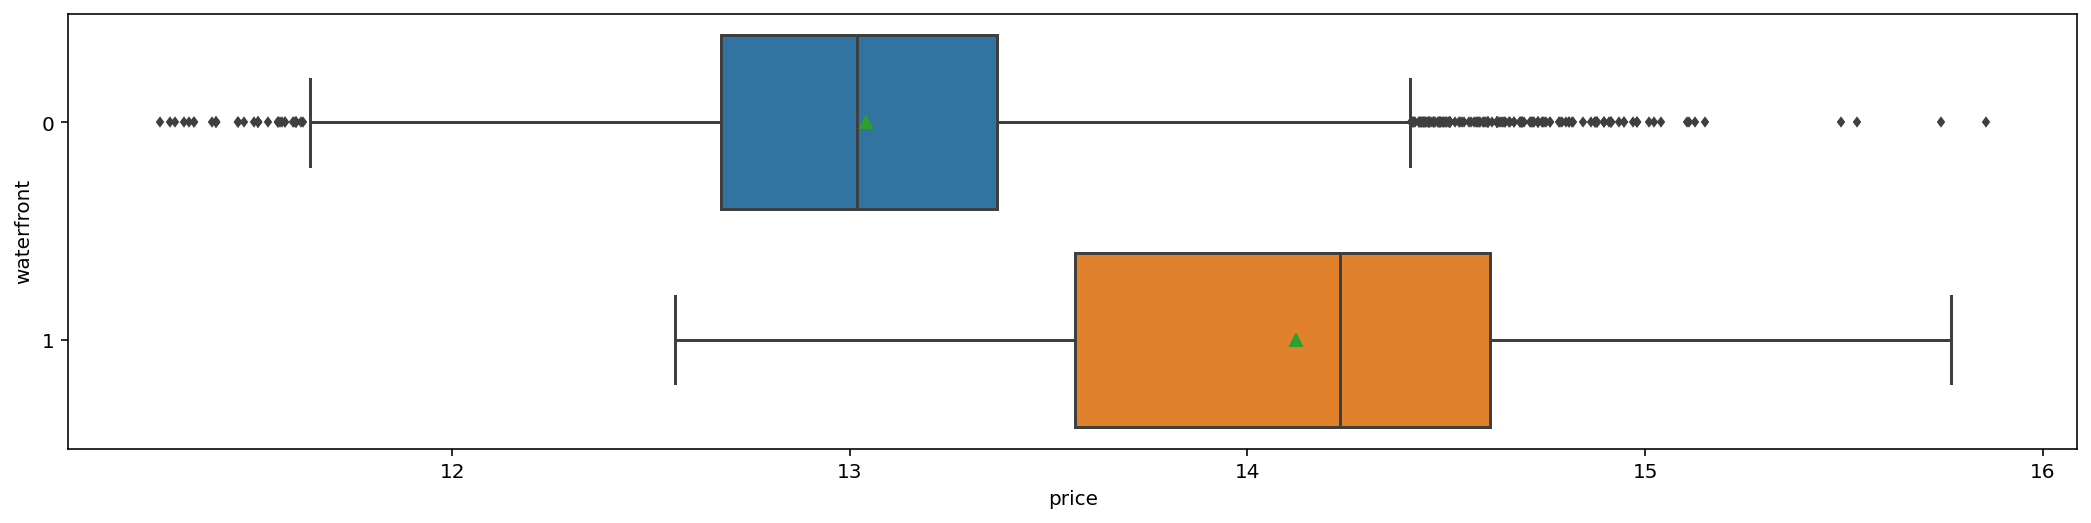

point biserial correlation r is 0.1725802357222813 with p = 7.451854937555299e-101


In [110]:
fig, ax = plt.subplots(figsize=(18,4))
sns.boxplot(y = 'waterfront', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.show()


r, p = stats.pointbiserialr(df_train['waterfront'], df_train['price'])
print('point biserial correlation r is %s with p = %s' %(r,p))

* 리버뷰가 없는 상자 플롯은 상대적으로 짧다. 
* 이는 전반적으로 이 그룹의 price가 서로 비슷하다는 것을 의미한다.
* 리버뷰 상자 플롯은 비교적 길다.
* 이는 price가 이 그룹 안에서 서로 크게 다르다는 것을 의미한다.
* 두 분포 사이에는 분명한 형태 차이를 보이고 있으며, 일반적으로 리버뷰의 주택이 더 높은 price는 갖는다.
* 두 변수 사이의 상관관계가 작더라도 여기서 아래 3가지를 확인하지 않았기 때문에 결과에 너무 의존할 수는 없다.
  * 연속 변수의 관점에서 이분형 변수의 두 그룹에 중요한 이상값이 없어야 한다.
  * 분산의 동질성이 있어야 한다.
  * 연속 변수가 이분형 변수의 각 그룹에 대해 대략적으로 정규 분포를 가져야 한다.

* `basement_present`와 과거 재건축 여부에 대해서도 동일하게 진행한다.

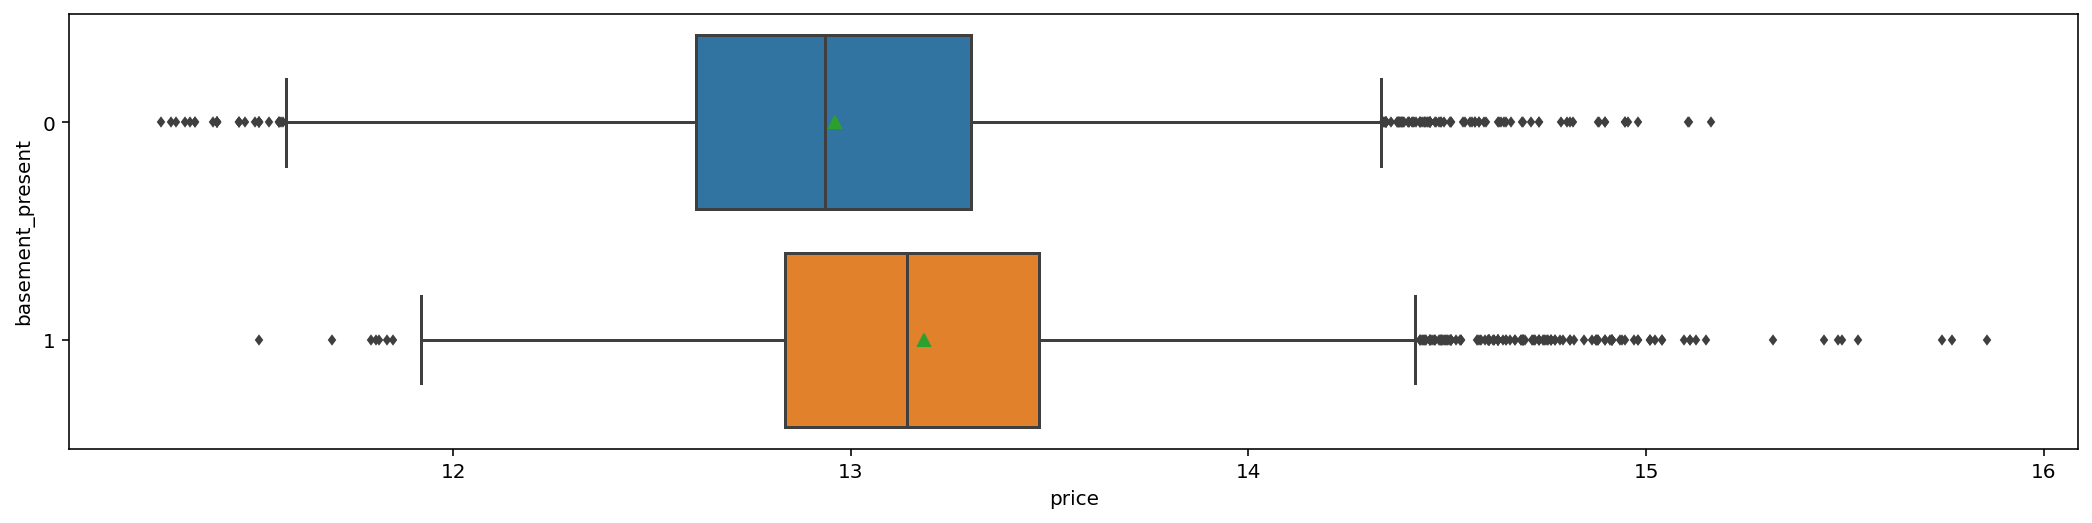

point biserial correlation r between price and basement_present is 0.2077259024713432 with p = 3.221005298505754e-146


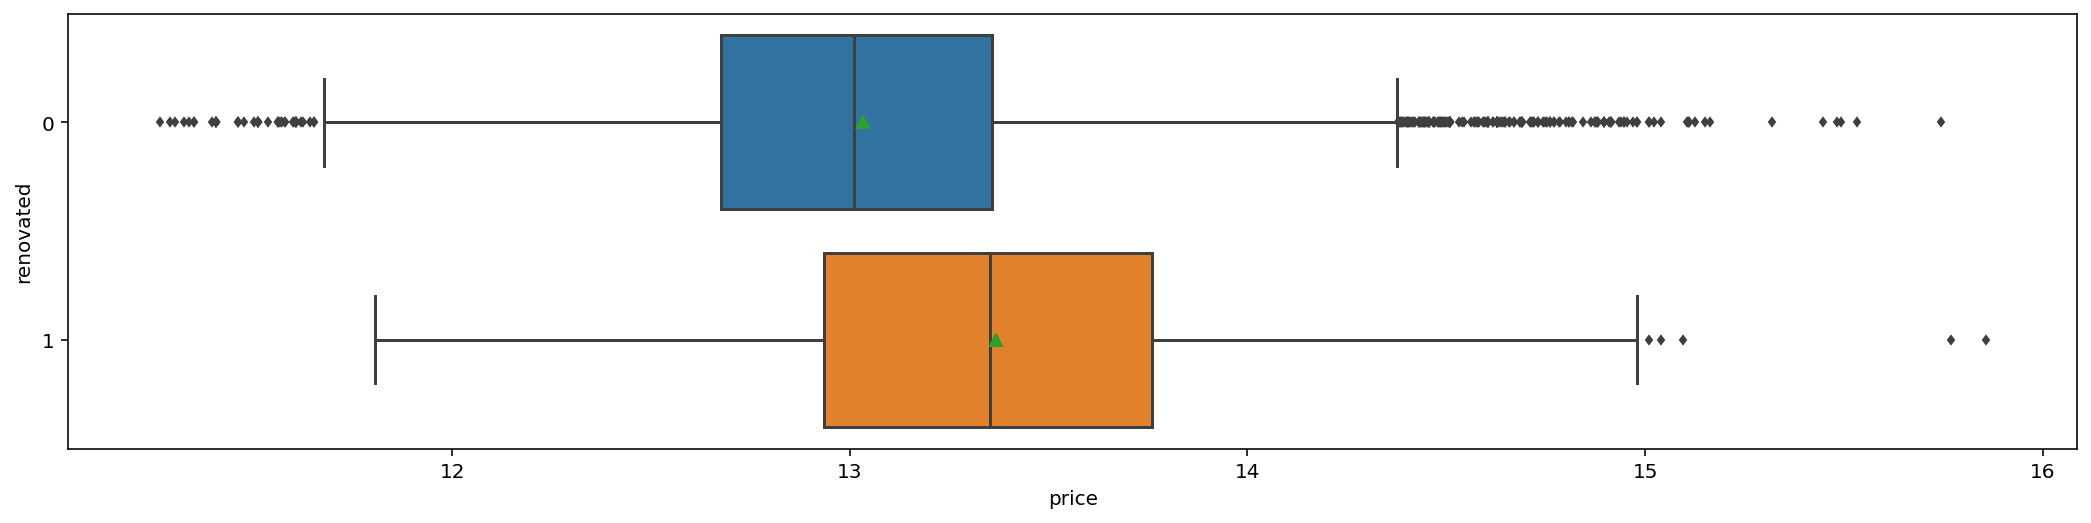

point biserial correlation r between price and renovated is 0.127241496478846 with p = 2.6485103319969934e-55


In [111]:
fig, ax = plt.subplots(figsize=(18,4))
sns.boxplot(y = 'basement_present', x = 'price', data =df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.show()
r, p = stats.pointbiserialr(df_train['basement_present'], df_train['price'])
print('point biserial correlation r between price and basement_present is %s with p = %s' %(r,p))

# renovated variable
fig, ax = plt.subplots(figsize=(18,4))
sns.boxplot(y = 'renovated', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.show()
r, p = stats.pointbiserialr(df_train['renovated'], df_train['price'])
print('point biserial correlation r between price and renovated is %s with p = %s' %(r,p))

* 연관성이 거의 없다.($0.1<r<0.3$)

* 순위변수(ordinal variable)로 price와의 연관성을 확인해본다.
* 박스플롯을 사용해 각 변수의 범주 분포를 보여준다.
* 참고 \
http://triki.net/study/3108#dry_toc_4

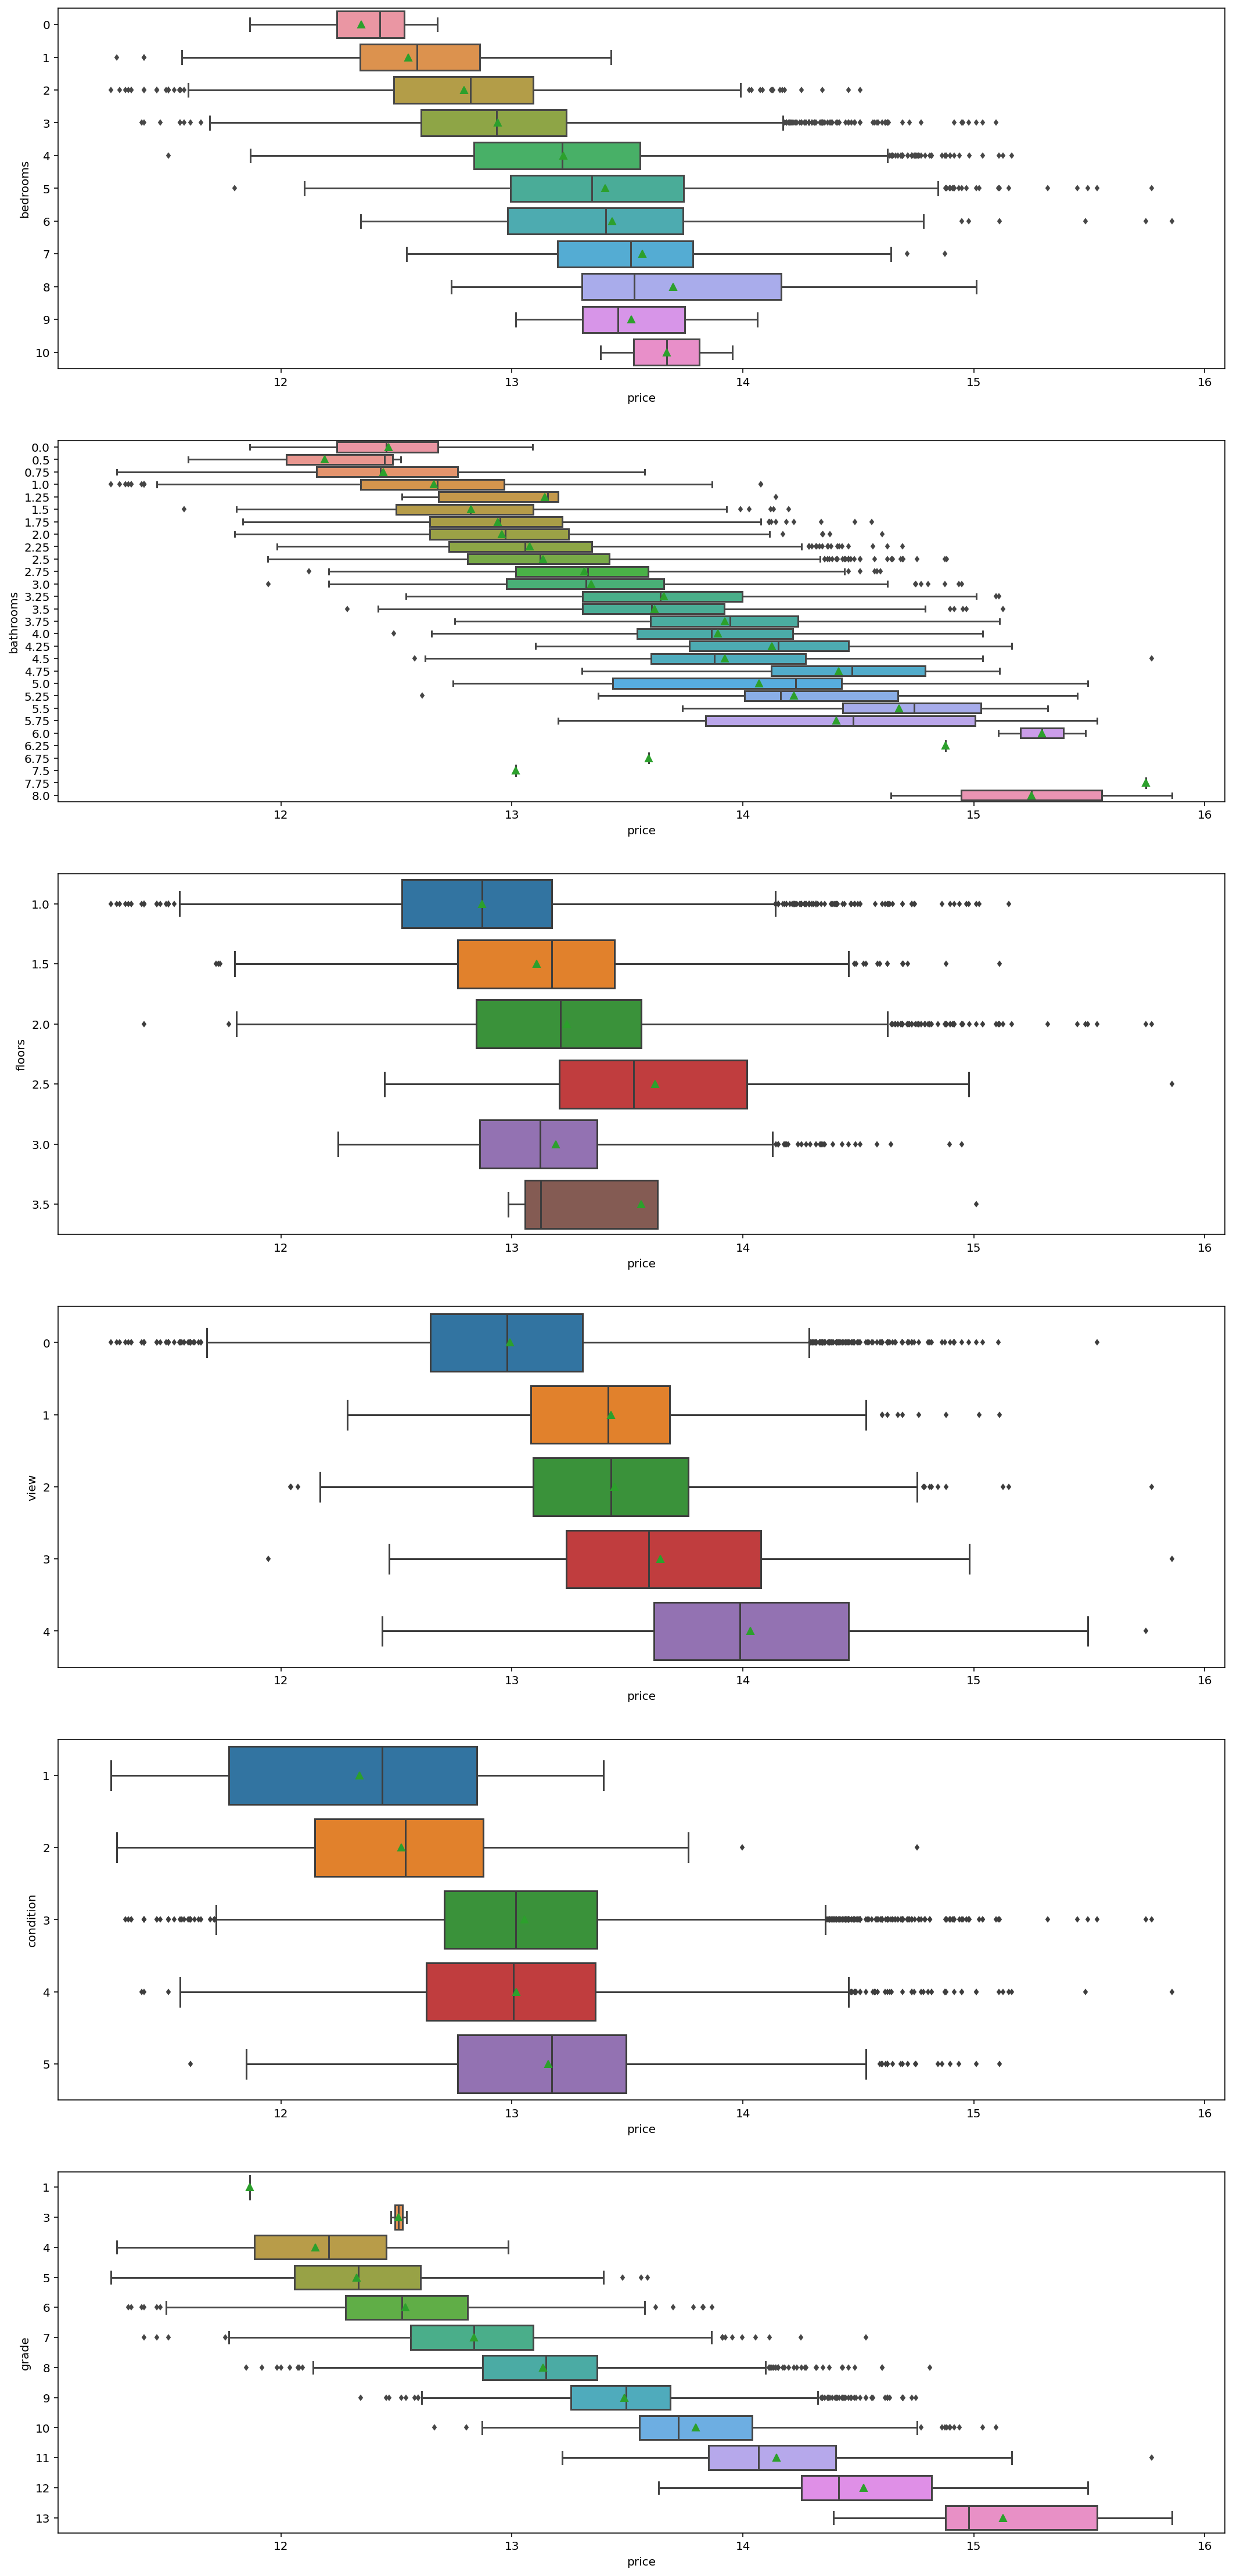

In [112]:
fig, axarr = plt.subplots(6, figsize=(18,40))
sns.boxplot(y = 'bedrooms', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[0])
sns.boxplot(y = 'bathrooms', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[1])
sns.boxplot(y = 'floors', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[2])
sns.boxplot(y = 'view', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[3])
sns.boxplot(y = 'condition', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[4])
sns.boxplot(y = 'grade', x = 'price', data = df_train, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[5])
plt.show()

* 예상한대로 모두 price와 관련이 있어 보인다.
* Spearman의 순위 상관 관계를 사용하여 `price`와 이러한 변수 간의 관계의 강도와 방향을 측정할 수 있다.

In [113]:
r, p = stats.spearmanr(df_train['bedrooms'], df_train['price'])
print('spearman correlation r between price and bedrooms is %s with p = %s' %(r,p))
r, p = stats.spearmanr(df_train['bathrooms'], df_train['price'])
print('spearman correlation r between price and bathrooms is %s with p = %s' %(r,p))
r, p = stats.spearmanr(df_train['floors'], df_train['price'])
print('spearman correlation r between price and floors is %s with p = %s' %(r,p))
r, p = stats.spearmanr(df_train['view'], df_train['price'])
print('spearman correlation r between price and view is %s with p = %s' %(r,p))
r, p = stats.spearmanr(df_train['condition'], df_train['price'])
print('spearman correlation r between price and condition is %s with p = %s' %(r,p))
r, p = stats.spearmanr(df_train['grade'], df_train['price'])
print('spearman correlation r between price and grade is %s with p = %s' %(r,p))

spearman correlation r between price and bedrooms is 0.3501849162071746 with p = 0.0
spearman correlation r between price and bathrooms is 0.49898891562255676 with p = 0.0
spearman correlation r between price and floors is 0.3286741155680268 with p = 0.0
spearman correlation r between price and view is 0.29171951557401904 with p = 1.028069352380221e-292
spearman correlation r between price and condition is 0.021520487889595537 with p = 0.008318284658970533
spearman correlation r between price and grade is 0.6621252562728034 with p = 0.0


* 변수들과 `price` 사이에는 실제로 연관성이 있다. (`condition` 제외). 
* `grade`가 가장 좋은 지표인 것 같다.

### 2.4 결론

* 지금까지 종속 변수(`price`)와 독립 변수 사이의 관계를 분석했다.
* 요약하자면,
  * `sqft_living`, `sqft_above` 및 `sqft_basement`는 `price`와 적당히/강하게 연관이 있다. 3개의 변수는 `sqft_living = sqft_above` 및 `sqft_basement`와 같이 서로 밀접한 관련이 있다.
  * `sqft_living15`, 가장 가까운 이웃 15개 주택의 평균 면적도 `price`(r=)와 밀접한 관련이 있었다. 그러나 `sqft_living`을 제어할 때 관계가 사라졌다.
  * `sqft_lot`, `sqft_lot15`(가장 가까운 주택 15채의 평균 부지 크기) 및 `yr_built`는 가격과 관련성이 낮다.
  * 세 가지 변수(`waterfront`, `basement_present`, `renovated`)는 가격과 연관이 있었지만, 정도가 적게 나타났다.
  * 다음 5개 변수(`bedrooms`, `bathrooms`, `floors`, `views`, `grade`)도 가격과 중간 ~ 매우 강한 정도로 연관이 있었다.  

### 3. 데이터 전처리

In [114]:
# 데이터 경로 지정하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

# 데이터를 df_train, df_test이라는 변수로 불러오기
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [115]:
df_train['price'] = np.log1p(df_train['price'])  

* `price`는 이전과 동일하게 정규화시켜준다.

### 3.1 이상치 제거

### 3.1.1 sqft_living

* 변수들에 대해 시각화하여 나타냈을 때, 다음 변수들에서 이상치가 확인되었다.
  * sqft_living  
  * grade  
  * bedrooms

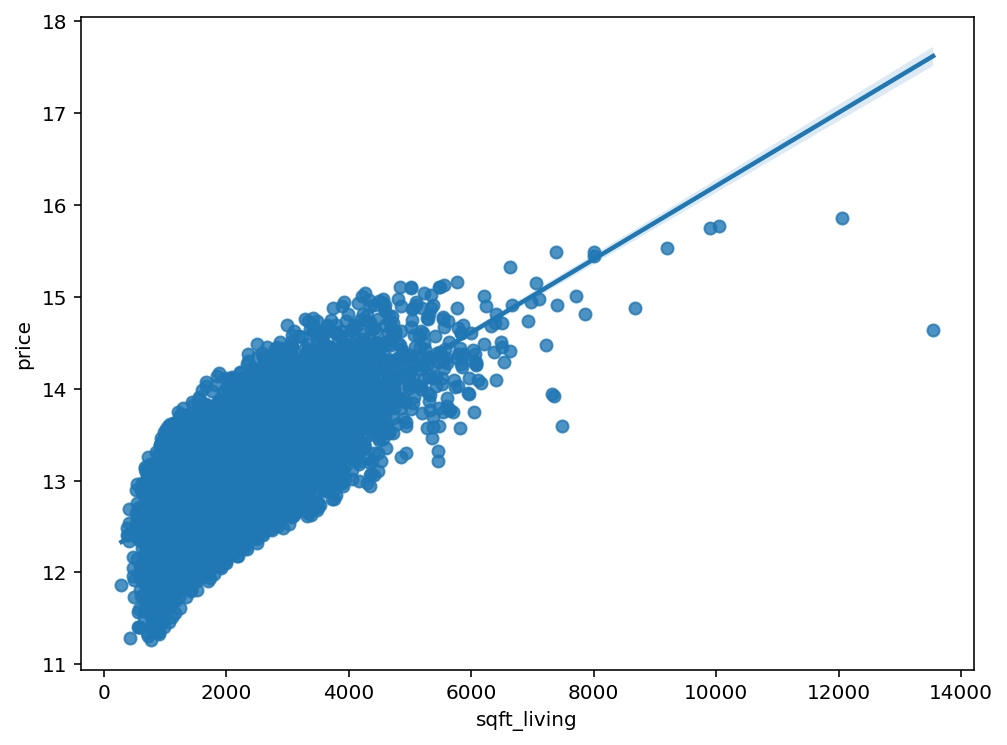

In [116]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [117]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


* 위의 값을 봤을 때, 다른 값들에 비해 `sqft_living`만 비정상적으로 꽤 큰 것을 알 수 있다. 
* 추가적으로 `price`와 상관성이 높은 `grade`와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 한다.

In [118]:
df_train = df_train.loc[df_train['id']!=8990]

### 3.1.2 grade

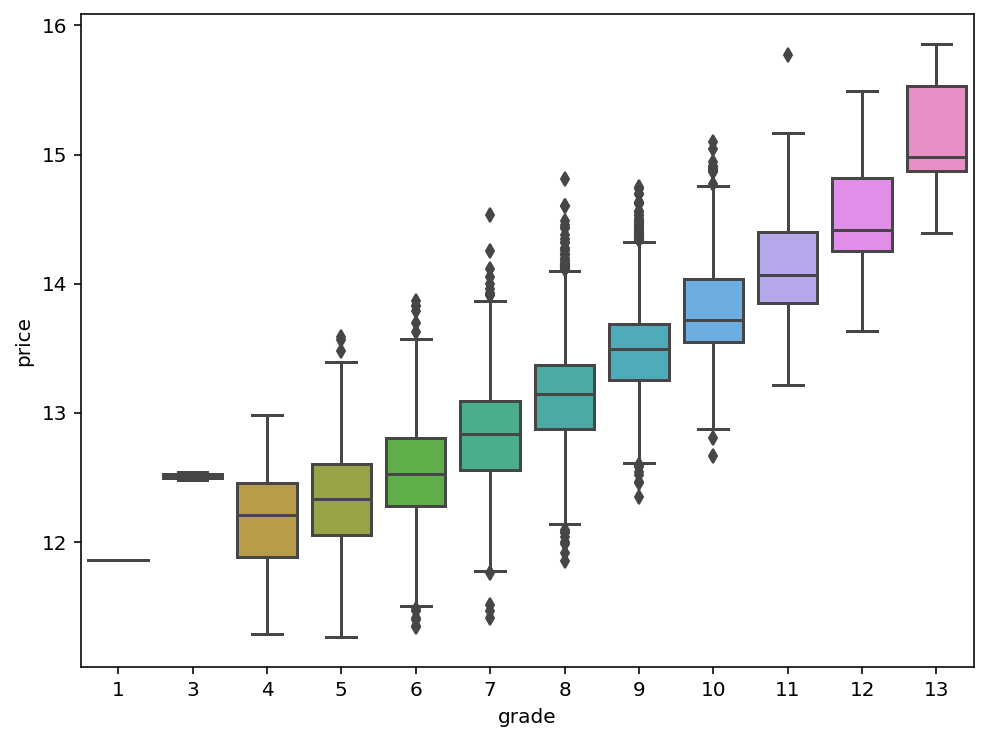

In [119]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [120]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


* grade, sqft_ 모두 낮은 것을 볼 수 있다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 한다.

In [121]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [122]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


* 위의 값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 한다.

In [123]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

### 3.1.3 bedrooms

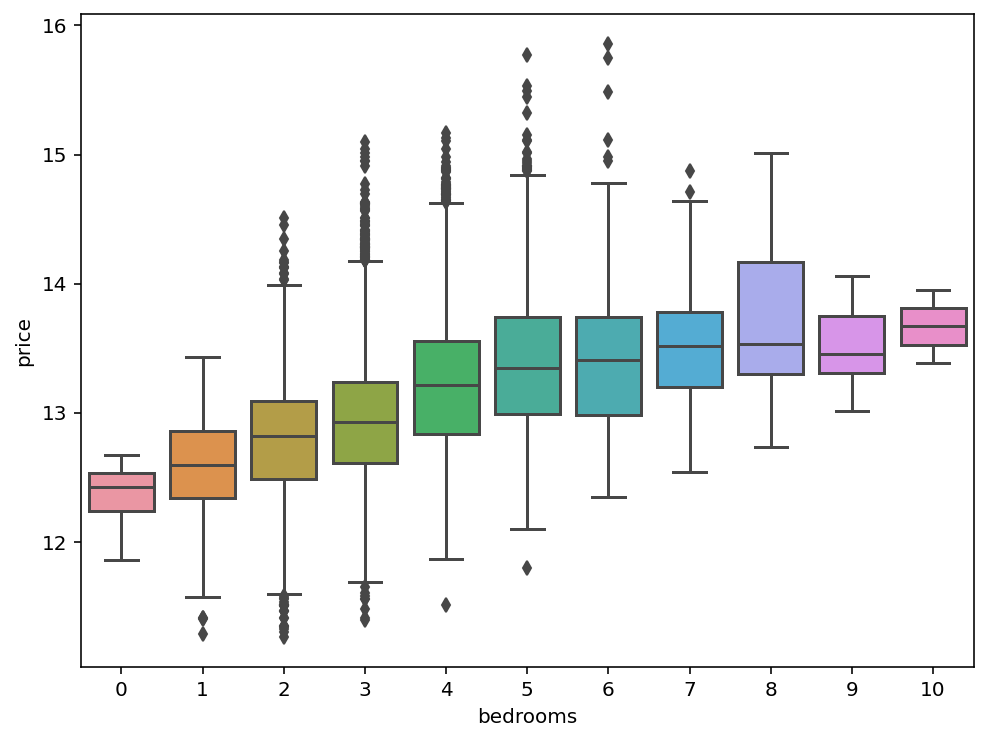

In [124]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

* `bedrooms`를 보면 양의 상관관계를 띄고 있다. 
* 그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있다. 
* 가운데의 값들은 다른 변수들의 영향이 크므로 제거하지는 않는다.

### 3.2 데이터 정규화

In [125]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

### 3.3 데이터 변형 (변수 수정)

### 3.3.1 date, sqft_basement, yr_renovated

In [126]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8]).astype(int)
    df['basement_present'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)    # 지하실 유무
    df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)           # 1이면 재건축

In [127]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement_present,renovated
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650,0,0
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062,0,0
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503,0,0
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819,0,0
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711,0,0


* `date`는 yyyymmdd의 형태로 변형
* `sqft_basement`는 지하실의 유무를 1과 0으로 변형
* `yr_renovated`는 재건축 유무를 1과 0으로 변형

### 3.3.2 price

In [128]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    df['date'] = df['date'].astype('int')

In [129]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

* 위의 `price` 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것이다. 
* 주의해야 할 점은 단순 `price`가 아니라 `평당 price`를 써야 한다는 점이다.

### 3.3.3 Age of House

In [130]:
df_train['age'] = 2015-df_train['yr_built']
df_test['age'] = 2015-df_test['yr_built']

* `yr_built`를 활용해 집의 나이 변수를 추가해준다.

In [131]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement_present,renovated,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,per_price,zipcode_mean,zipcode_var,age
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650,0,0,4.00,0.818803,7.074117,1.0,0.237168,1.740145,9.368147,1.214207,60
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062,0,0,3.00,0.721756,6.647688,1.0,0.337385,1.820290,9.257745,1.023549,82
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503,0,0,5.00,0.825489,7.427144,1.0,0.239904,1.769478,11.307711,0.826257,28
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819,0,0,5.25,0.843688,7.447751,1.0,0.328201,1.672824,10.626177,1.012780,20
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711,0,0,4.50,0.758837,6.966967,1.0,0.169910,1.806238,10.032009,1.002206,52


### 4. 모델링

* 다양한 모델 참고 자료 \
https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.  \
https://subinium.github.io/introduction-to-ensemble-2-boosting/

### 4.1 단순 선형회귀(OLS)

In [132]:
train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2178.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:06:33   Log-Likelihood:                 39.002
No. Observations:               15030   AIC:                            -24.00
Df Residuals:                   15003   BIC:                             181.7
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
date              5.264e-06   4.47e-07  

* Adj. R-squared : 1.000 → 모델의 설명력이 약 100%라고 볼 수 있다.
* 하지만 각각의 변수들 중에서는 p-value가 높은 값들이 있음을 확인할 수 있다. 
* 이에 대한 원인은 아래와 같이 생각해 볼 수 있다.
  * FE해서 나온 파생변수들은 기존의 변수와 연관되어있다.
  * sqft_로 시작하는 변수들끼리의 상관성
* 따라서, 다중공선성의 문제를 가지기 때문으로 볼 수 있다.
* 참고 \
https://ysyblog.tistory.com/119 \
https://learnx.tistory.com/entry/%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1Multicollinearity%EC%9D%B4%EB%9E%80 \
https://bkshin.tistory.com/entry/DATA-20-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC-VIF \
https://muzukphysics.tistory.com/entry/%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1-%ED%8C%90%EB%8B%A8-%EA%B8%B0%EC%A4%80-%EB%B0%8F-%ED%95%B4%EA%B2%B0-%EB%B0%A9%EB%B2%95-VIF-%ED%99%95%EC%9D%B8-Multicollinearity

### 4.1.1 다중공선성 확인

In [133]:
vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
13,sqft_basement,inf
4,bathrooms,inf
23,total_rooms,inf
12,sqft_above,inf
25,sqft_total_size,inf
3,bedrooms,inf
14,yr_built,2.535087e+07
31,age,1.829421e+04
15,yr_renovated,1.758191e+04
22,renovated,1.758011e+04


* 보통의 경우 10 이상이면 다중공선성이 존재한다고 말한다.
* 위의 결과에서는 `sqft_living15`, `floors`, `long`, `sqft_lot15`, `lat`, `zipcode`, `view`, `condition`, `waterfront`, `date` 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있다.
* `sqft_`로 시작하는 변수들끼리의 상관성이 영향이 꽤 있다 판단되므로 sqft_로 시작하는 일부 변를 삭제한다.
* 그 외 독립변수 사이 상관관계가 있어 보이는 변수들은 삭제한다.
* `sqft_living`, `yr_built`, `zipcode_mean`, `zipcode_var`, `yr_renovated`, `per_price` 삭제

### 4.2 변수 삭제 

In [52]:
del df_train['sqft_living']
del df_train['yr_built']
del df_train['zipcode_mean']
del df_train['zipcode_var']
del df_train['yr_renovated']
del df_train['per_price']
del df_train['id']

print(df_train.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'basement_present', 'renovated', 'total_rooms',
       'sqft_ratio', 'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'age'],
      dtype='object')


In [53]:
del df_test['sqft_living']
del df_test['yr_built']
del df_test['zipcode_mean']
del df_test['zipcode_var']
del df_test['yr_renovated']
del df_test['id']

print(df_test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement_present',
       'renovated', 'total_rooms', 'sqft_ratio', 'sqft_total_size',
       'sqft_ratio_1', 'sqft_ratio15', 'age'],
      dtype='object')


In [54]:
y = df_train['price']
del df_train['price']

train = df_train
test = df_test

### 4.3 Grid Search

### 4.3.1 모델 하이퍼파라미터 탐색

In [55]:
random_state=2022     # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

rdforest = RandomForestRegressor(random_state=random_state)

In [56]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### 4.3.2 RandomForestRegressor GridSearch

In [57]:
param_grid = [
    {'n_estimators': [3, 10, 30, 60]},
    {'bootstrap': [True], 'n_estimators': [3, 10, 30, 60]},
]

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,n_estimators,bootstrap,score,RMSLE
3,60,NaN,-0.032972,0.181582
7,60,True,-0.032972,0.181582
2,30,NaN,-0.033593,0.183285
6,30,True,-0.033593,0.183285
1,10,NaN,-0.036060,0.189896
5,10,True,-0.036060,0.189896
0,3,NaN,-0.046552,0.215758
4,3,True,-0.046552,0.215758


In [58]:
model = RandomForestRegressor(n_estimators=3)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.09122584, 12.95097013, 13.92120178, ..., 13.08352085,
       12.54992626, 12.99390168])

### 4.4 모델의 학습 및 예측

### 4.4.1 모델 별 Validation 및 모델 학습 점수

In [59]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### 4.4.1.1 GradientBoostingRegressor

In [60]:
model_gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(model_gbr)
print("\nGradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[CV] END .....................................n_estimators=3; total time=   0.7s
[CV] END ....................................n_estimators=10; total time=   2.6s
[CV] END ....................................n_estimators=30; total time=  10.4s
[CV] END ....................................n_estimators=60; total time=  14.5s
[CV] END .....................bootstrap=True, n_estimators=3; total time=   1.4s
[CV] END ....................bootstrap=True, n_estimators=10; total time=   3.4s
[CV] END ....................bootstrap=True, n_estimators=30; total time=   7.4s
[CV] END ....................bootstrap=True, n_estimators=60; total time=  17.0s
[CV] END .....................................n_estimators=3; total time=   0.8s
[CV] END ....................................n_estimators=10; total time=   3.1s
[CV] END ....................................n_estimators=30; total time=  11.0s
[CV] END ....................................n_estimators=60; total time=  17.3s
[CV] END ...................

### 4.4.1.2 XGBRegressor

In [61]:
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("\nXGBRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[05:37:53] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:38:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:38:18] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:38:30] WARNI

### 4.4.1.3 LGBRegressor

In [62]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("\nXGBRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

### 4.4.1.4 RandomForestRegressor

In [63]:
model_rf = RandomForestRegressor(n_estimators=3)
score = rmsle_cv(model_rf)
print("\nRandomForestRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


RandomForestRegressor score: 0.2124 (0.0077)



### 4.4.1.5 CatBoostRegressor

In [64]:
model_cb = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=4, l2_leaf_reg=20, 
                             bootstrap_type='Bernoulli', subsample=0.6, eval_metric='RMSE', 
                             metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
score = rmsle_cv(model_cb)
print("\nCatBoostRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

0:	learn: 0.4941548	total: 48.9ms	remaining: 48.8s
50:	learn: 0.2040573	total: 123ms	remaining: 2.28s
100:	learn: 0.1831508	total: 191ms	remaining: 1.7s
150:	learn: 0.1730019	total: 259ms	remaining: 1.46s
200:	learn: 0.1677444	total: 328ms	remaining: 1.3s
250:	learn: 0.1636735	total: 396ms	remaining: 1.18s
300:	learn: 0.1603651	total: 465ms	remaining: 1.08s
350:	learn: 0.1577234	total: 533ms	remaining: 985ms
400:	learn: 0.1554718	total: 602ms	remaining: 899ms
450:	learn: 0.1534749	total: 670ms	remaining: 816ms
500:	learn: 0.1519879	total: 740ms	remaining: 737ms
550:	learn: 0.1506550	total: 809ms	remaining: 659ms
600:	learn: 0.1491562	total: 879ms	remaining: 583ms
650:	learn: 0.1477925	total: 946ms	remaining: 507ms
700:	learn: 0.1467116	total: 1.01s	remaining: 432ms
750:	learn: 0.1455793	total: 1.08s	remaining: 358ms
800:	learn: 0.1444618	total: 1.15s	remaining: 285ms
850:	learn: 0.1433897	total: 1.22s	remaining: 213ms
900:	learn: 0.1423457	total: 1.29s	remaining: 142ms
950:	learn: 0.14

600:	learn: 0.1486086	total: 836ms	remaining: 555ms
650:	learn: 0.1474782	total: 904ms	remaining: 484ms
700:	learn: 0.1463496	total: 975ms	remaining: 416ms
750:	learn: 0.1452082	total: 1.05s	remaining: 347ms
800:	learn: 0.1440580	total: 1.12s	remaining: 278ms
850:	learn: 0.1429743	total: 1.19s	remaining: 208ms
900:	learn: 0.1420636	total: 1.26s	remaining: 139ms
950:	learn: 0.1410343	total: 1.33s	remaining: 68.7ms
999:	learn: 0.1401183	total: 1.4s	remaining: 0us
0:	learn: 0.4948679	total: 1.99ms	remaining: 1.98s
50:	learn: 0.2038306	total: 76.4ms	remaining: 1.42s
100:	learn: 0.1838983	total: 147ms	remaining: 1.31s
150:	learn: 0.1731489	total: 218ms	remaining: 1.23s
200:	learn: 0.1672204	total: 290ms	remaining: 1.15s
250:	learn: 0.1630714	total: 364ms	remaining: 1.08s
300:	learn: 0.1597279	total: 445ms	remaining: 1.03s
350:	learn: 0.1569650	total: 532ms	remaining: 983ms
400:	learn: 0.1549207	total: 616ms	remaining: 920ms
450:	learn: 0.1528360	total: 685ms	remaining: 834ms
500:	learn: 0.1

### 4.4.2 모델 별 예측

* RMSE (Root-Mean-Square Error)
  * 잔차(예측 오차)의 표준편차이다. 잔차는 회쉬선 데이터 포인트에서 얼마나 멀리 떨어져 있는지 측정한다. RMSE는 이러한 잔차가 얼나마 분산되어 있는지 측정한다. 즉, 데이터가 가장 적합한 선 주위에 얼마나 집중되어 있는지 알려준다.
  * 값이 작을수록 정밀도가 높다.
  * 모델 또는 추정자가 예측한 값 (샘플 또는 모집단 값)과 관찰된 값 간의 차이를 측정하는데 자주 사용된다. 
  * 주로 회귀분석에서 이격도를 확인하는데 주로 사용하는데, 비선형적인 방법을 통한 검증에는 주로 활용되지는 않는 편이나 쓸 수는 있다.
  * 에러가 예측하려는 값의 크기에 의존적이라는 면에서 RMSE는 크기 의존적 에러(Scale-dependent Errors)에 속한다.
* 참고 \
https://koreapy.tistory.com/529 \
https://brunch.co.kr/@chris-song/34

In [65]:
def rmsle(y, y_pred): 
    return np.sqrt(mean_squared_error(y, y_pred))

### 4.4.2.1 GradientBoostingRegressor

In [66]:
model_gbr.fit(train, y)
train_pred = model_gbr.predict(train)
gbr_pred = np.expm1(model_gbr.predict(test))
print(rmsle(y, train_pred))

0.11239171398239439


### 4.4.2.2 XGBRegressor

In [67]:
model_xgb.fit(train, y)
train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y, train_pred))

[05:41:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.12969515056025335


### 4.4.2.3 LGBRegressor

In [68]:
model_lgb.fit(train, y)
train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(rmsle(y, train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.16847294062632265


### 4.4.2.4 RandomForestRegressor

In [69]:
model_rf.fit(train, y)
train_pred = model_rf.predict(train)
rf_pred = np.expm1(model_rf.predict(test))
print(rmsle(y, train_pred))

0.1084766579228214


### 4.4.2.5 CatBoostRegressor

In [70]:
model_cb.fit(train, y)
train_pred = model_cb.predict(train)
cb_pred = np.expm1(model_cb.predict(test))
print(rmsle(y, train_pred))

0:	learn: 0.4966765	total: 1.88ms	remaining: 1.88s
50:	learn: 0.2035899	total: 80.9ms	remaining: 1.5s
100:	learn: 0.1834158	total: 163ms	remaining: 1.46s
150:	learn: 0.1726069	total: 245ms	remaining: 1.38s
200:	learn: 0.1674069	total: 322ms	remaining: 1.28s
250:	learn: 0.1637388	total: 394ms	remaining: 1.17s
300:	learn: 0.1603589	total: 469ms	remaining: 1.09s
350:	learn: 0.1577469	total: 550ms	remaining: 1.02s
400:	learn: 0.1558125	total: 625ms	remaining: 933ms
450:	learn: 0.1537268	total: 702ms	remaining: 855ms
500:	learn: 0.1521217	total: 780ms	remaining: 777ms
550:	learn: 0.1508564	total: 854ms	remaining: 696ms
600:	learn: 0.1496237	total: 931ms	remaining: 618ms
650:	learn: 0.1481826	total: 1.01s	remaining: 542ms
700:	learn: 0.1471894	total: 1.08s	remaining: 463ms
750:	learn: 0.1461014	total: 1.16s	remaining: 385ms
800:	learn: 0.1449344	total: 1.24s	remaining: 308ms
850:	learn: 0.1438446	total: 1.31s	remaining: 230ms
900:	learn: 0.1428966	total: 1.39s	remaining: 153ms
950:	learn: 0.

### 4.5 Averaged base models class

In [71]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [72]:
averaged_models = AveragingModels(models = (model_gbr, model_xgb, model_lgb, model_rf))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[05:42:31] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[05:43:39] WARNING: ../src/learner.cc:573: 
Parameters: { "

[05:52:36] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
 Averaged base models score: 0.1636 (0.0075)



### 4.6 StackingAveragedModels

* 기반모델 : GradientBoostingRegressor, XGBRegressor, LGBRegressor, RandomForestRegressor
* 메타모델 : CatBoostRegressor

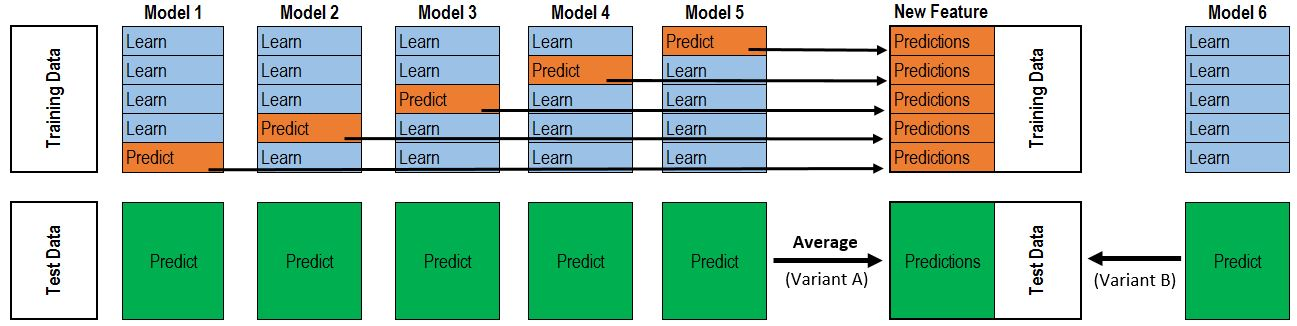

* 참고 \
https://kimdingko-world.tistory.com/186 \
https://www.kaggle.com/dlscjs5362/stacking-model-fit-suwon-study \
https://inspiringpeople.github.io/data%20analysis/Ensemble_Stacking/

In [73]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [74]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_gbr, model_xgb, model_lgb, model_rf),
                                                 meta_model = model_cb)

In [75]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [76]:
stacked_averaged_models.fit(train.values, y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y, stacked_train_pred))

[05:56:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:57:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:57:15] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:57:26] WARNI

### 5. 결과

### 5.1 모델 별 RMSE

* GradientBoostingRegressor : 0.11239171398239439
* XGBRegressor : 0.12969515056025335
* LGBRegressor : 0.16847294062632265
* RandomForestRegressor : 0.10518502091743957
* CatBoostRegressor : 0.1410019663622063

### 5.2 Averaged base models class RMSE

* Averaged base models score: 0.1637

### 5.3 StackingAveragedModels RMSE

*  Stacking averaged models score: 0.12058301506452522

* averaging한 결과보다 stacking한 결과가 확실히 더 좋게 나오는 것을 확인할 수 있었다.
* 그러나 단일 모델 예측 결과(RandomForestRegressor) stacking 점수보다 더 좋게 나오는 것이 확인되었다.
* 뭔가 데이터 상 제대로 정제되지 못한 내용들이 있었을 가능성이 있어 보인다.

### 6. submission

In [77]:
prediction = np.expm1(model_cb.predict(test))
prediction

array([ 525345.33519172,  455248.07772935, 1356500.40882783, ...,
        462864.91054622,  303551.38860684,  418967.60321552])

In [78]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [79]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.253453e+05
1,15036,4.552481e+05
2,15037,1.356500e+06
3,15038,3.064931e+05
4,15039,3.192258e+05


In [80]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


### 7. 회고

### 7.1 이번 프로젝트에서 어려웠던 점

* 데이터를 로드해 분석하고 정제하는 것부터 모델링, 예측, 평가까지 일련의 과정을 전부 다 하는 것이 처음이였어서 힘들었다.
* 한 단계, 한 단계 넘어갈 수록 모르는게 너무 많아 이해해가면서 진행하느라 시간이 오래 걸렸다. 

### 7.2 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

### 7.2.1 알게된 내용

* pandas profiling
* 왜도, 첨도
* 공변량
* 상관계수
* 다양한 모델
* 다중공선성
* 스태킹 기법은 single 모델보다 더 높은 정확도를 가져오지만 많은 시간이 소요되고, computation cost가 높기 때문에 실무보다는 Kaggle 같은 경연대회에서 많이 쓰인다. \
  (실제 넷플릭스의 추천알고리즘 대회에서 1등한 알고리즘은 너무 복잡하다는 이유로 넷플릭스에선 쓰지 않기로 결정했다고 한다.)
https://inspiringpeople.github.io/data%20analysis/Ensemble_Stacking/ 
* 스태킹의 경우 모델이 쌓이는 모양 및 순서에 따라서도 결과에 영향을 미친다고 한다. \
https://www.analyticsvidhya.com/blog/2021/03/advanced-ensemble-learning-technique-stacking-and-its-variants/ 
* 다중 스태킹 \
https://www.koreascience.or.kr/article/JAKO202025551105920.pdf

### 7.2.2 아직 모호한 점

* 스태킹이 진행될 때 데이터의 행렬 변화에 대해 아직 다 이해를 하지 못함.
* Feature Engineering을 어떻게 진행해야 원하는 결과를 두출해낼 수 있는지에 대해 감이 잡히지 않음.
* 각 모델들의 특징 및 장점에 대한 이해

### 7.3 루브릭 평가 지표를 맞추기 위해 시도한 것들

* 여러 모델을 사용하여 진행
* 여러 모델을 모아 Average 진행
* 여러 모델을 모아 stacking 진행
* GridSearch 사용

### 7.4 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정.

* 선택한 모델들에는 문제가 없다 판단된다. 같은 모델을 사용한다하더라도 결과가 사람들마다 다르게 나타나는 경우가 많기 때문
* 모델의 예측점수가 생각보다 잘 나오지 못한 이유
  * 하이퍼파라미터 : GridSearch를 사용하긴 했으나, RF모델에서만 사용했다. 모델 별로 적절한 하이퍼파라미터를 찾는다면 더 나은 결과가 나올 수 있을 것이라 생각된다.
  * 데이터 탐색 및 전처리 과정에서 집값을 예측 할 수 있는 최적의 상태로 데이터가 만들어지지 못한 것 같다.
  * 기존 변수와 기존 변수, 새로 만든 변수와 기존 변수 사이에서 다중공선성이 확인되어 일부 변수를 삭제했는데, 이에 대한 영향도 없지 않은 것 같다.

### 7.5 자기 다짐

* 그렇게 많은 양의 데이터라고 생각하지 않았는데, 생각보다 해야 할 것들이 많았다.
* 시간 투자 대비 결과가 좋지 못했는데, 데이터를 제대로 잘 처리하지 못한 것이 원인으로 생각되고 데이터 처리에 대한 부분은 다양한 경험을 해보면서 감을 잡는 것이 좋을 듯하다.
* 새로 알게된 내용과 모호한 점에 대해서는 다시 한 번 리마인드가 필요하다.

### 7.6 추가 참고 내용

* Pandas-Profiling을 사용한 EDA \
https://wikidocs.net/47193 \
https://kanoki.org/2019/01/15/pandas-exploratory-data-analysis-data-profiling/

In [81]:
#data_dir1 = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/train.csv'
#raw = pd.read_csv(data_dir1)
#report = raw.profile_report()
#report.to_file('report_train.html')

* report_train.html\
https://8888-wdd0j8oejwvajo50ym33mhyxr.e.prod.connect.ainize.ai/view/aiffel/report_train.html

In [82]:
#data_dir2 = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/test.csv'
#raw = pd.read_csv(data_dir2)
#report = raw.profile_report()
#report.to_file('report_test.html')

* report_test.html\
https://8888-wdd0j8oejwvajo50ym33mhyxr.e.prod.connect.ainize.ai/view/aiffel/report_test.html

* 데이터 탐색 및 전처리 시 참고한 자료 \
https://www.kaggle.com/fulrose/eda-with-map-visualization?scriptVersionId=12681748
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook?scriptVersionId=12697460
https://www.kaggle.com/seholeee/house-price-prediction-practice-eda